* reward function: with coefficient
* accuracy estimation: with predictor
* next item sampling: with random_choice
* input to lstm: tokens expanded
* data_x: without 0-steps

Tokens expanded
* lstm input shape: (6, 5) 
* 5: no. of layers, 6: layer infos
* input to predict: (1, 6, 5)
* predicted output shape: (1, 6, 382) return_sequences=True
* predicts layer params

In [1]:
import numpy as np
import keras
import random
import matplotlib.pyplot as plt 
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Dropout
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import keras.backend as K
import scipy.stats as stats
import math
import tensorflow as tf
import itertools
from typing import List

In [2]:
baseline = -5
rew_coef = 1
loss_alpha = 0.9
# rnn_lr = 0.01 
# rnn_decay = 0.1
no_of_nas_epochs = 100
no_of_samples_per_epoch = 5
max_no_of_layers = 6
rnn_train_epochs = 32
distribution_space = np.linspace(1,32,32)
rnn_dim = int(distribution_space[-1])
no_of_layer_params = 6

In [3]:
def plot_distribution(samples, prob, next_):
    fig, axs = plt.subplots(len(next_), figsize=(24, 6))
    for i in range(len(next_)):
        axs[i].axvline(x=next_[i], c="r", alpha=0.5)
        axs[i].plot(distribution_space, prob[i])
        axs[i].axis('off')    
    plt.show()

In [4]:
acc_model = keras.models.load_model("accuracy_predictor.h5")
def performance_estimate(sequence):
    seq_hot = keras.utils.to_categorical(sequence[:-1], num_classes=383)[np.newaxis]
    acc = acc_model.predict(seq_hot)[0][0]
    return round(acc, 3)

In [5]:
def discount_reward(rewards):
    discounted_reward = []
    for t in range(len(rewards)):
        dis_reward = 0
        for i, r in enumerate(rewards[t:]):
            dis_reward = loss_alpha**(i-t) * r
        discounted_reward.append(dis_reward)
    discounted_reward = tf.stack(discounted_reward)
    if len(rewards) > 1:
        discounted_reward = (discounted_reward - K.mean(discounted_reward)) / K.std(discounted_reward)
    return discounted_reward

In [6]:
def reinforce(y_true, y_pred):
    rewards = rew_coef * (data_acc - baseline)
    discounted_rewards = discount_reward(rewards)
    y_pred = K.clip(y_pred, 1e-36, 1e36)
    loss = - K.log(y_pred) * discounted_rewards[:, None]
    return loss

In [7]:
ranges = {
    "layers": [1, 2, 3],  # 1:"Conv2D", 2:"DepthwiseConv2D", 3:"Dense", 4:"dropout", 5:"last"
    "filters": [8, 16, 24, 32, 40],
    "nodes": [4, 8, 12, 16, 20, 24, 28, 32, 36, 40],
    "kernel_sizes": [1, 2, 3],  # 1:[1, 1], 2:[2, 2], 3:[3, 3]
    "strides": [1, 2, 3],  # 1:[1, 1], 2:[2, 2], 3:[3, 3]
    "paddings": [1, 2],  # 1:"valid", 2:"same"
    "activations": [1, 2],  # 1:"sigmoid", 2:"relu"
        }

In [8]:
# def expand_token(sequence):
def get_dictionary() -> List:
    cnn_params = list(itertools.product(*[ranges["layers"][:-1], ranges["filters"], ranges["kernel_sizes"], ranges["strides"], ranges["paddings"], 
                                          ranges["activations"]]))
    dense_params = list(itertools.product(*[[3], ranges["nodes"], [0], [0], [0], ranges["activations"]]))
    last_params = [[4, 2, 0, 0, 0, 0], [5, 2, 0, 0, 0, 0]]  # dropout 0.2, softmax 2
    dictionary = cnn_params + dense_params #+ last_params
    return dictionary
#     expanded = [dictionary[i-1] for i in sequence]
#     return expanded

In [9]:
def map_dist_to_layer_param(dist: List, param_name: str, selected: int) -> int:
    if param_name is None:
        return 0
    range_ = ranges[param_name]
    stp = int(math.ceil(len(dist)/len(range_)))
    mapped = [item for sublist in [[i]*stp for i in range_] for item in sublist]

    while len(mapped) > len(dist):
        s = np.random.randint(len(mapped))
        del mapped[s]
    value = mapped[selected-1]
    return value

In [10]:
# model = None
# main_input = keras.engine.input_layer.Input(shape=(max_no_of_layers-1, no_of_layer_params), batch_shape=None, name="main_input")
# x = keras.layers.LSTM(rnn_dim, return_sequences=True)(main_input)
# x = keras.layers.LSTM(rnn_dim, return_sequences=True)(x)
# x = keras.layers.LSTM(rnn_dim, return_sequences=True)(x)
# x = keras.layers.LSTM(rnn_dim, return_sequences=True)(x)
# x = keras.layers.LSTM(rnn_dim, return_sequences=True)(x)
# x = keras.layers.LSTM(rnn_dim, return_sequences=True)(x)
# x = keras.layers.LSTM(rnn_dim, return_sequences=True)(x)
# x = keras.layers.LSTM(rnn_dim, return_sequences=True)(x)
# main_output = keras.layers.Dense(len(distribution_space), activation="softmax", name="main_output")(x)
# model = keras.models.Model(inputs=[main_input], outputs=[main_output])

In [11]:
model = None
main_input = keras.engine.input_layer.Input(shape=(no_of_layer_params, max_no_of_layers-1), batch_shape=None, name="main_input")
x = keras.layers.LSTM(rnn_dim, return_sequences=True)(main_input)
x = keras.layers.LSTM(rnn_dim, return_sequences=True)(x)
main_output = keras.layers.Softmax(name="main_output", axis=-1)(x)
model = keras.models.Model(inputs=[main_input], outputs=[main_output])

In [12]:
# model.compile(loss={"main_output": reinforce}, optimizer=keras.optimizers.Adam(lr=rnn_lr, decay=rnn_decay, clipnorm=1.0))
model.compile(loss={"main_output": reinforce}, optimizer=keras.optimizers.Adam())

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 6, 5)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 6, 32)             4864      
_________________________________________________________________
lstm_1 (LSTM)                (None, 6, 32)             8320      
_________________________________________________________________
main_output (Softmax)        (None, 6, 32)             0         
Total params: 13,184
Trainable params: 13,184
Non-trainable params: 0
_________________________________________________________________


In [14]:
# keras.utils.plot_model(model, "lstm.png", show_shapes=True)

NAS epoch 1
Epoch average accuracy (5 sequences): 0.65


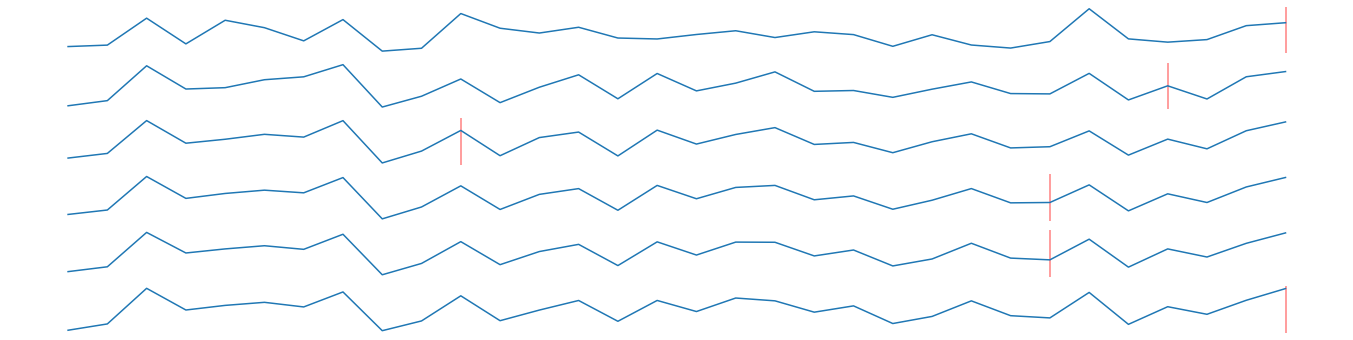

Training lstm ..
Rewards: [5.53, 5.812, 5.8, 5.588, 5.519]
lstm loss (epochs average): 4.043288722588301e-05
NAS epoch 2
Epoch average accuracy (5 sequences): 0.66


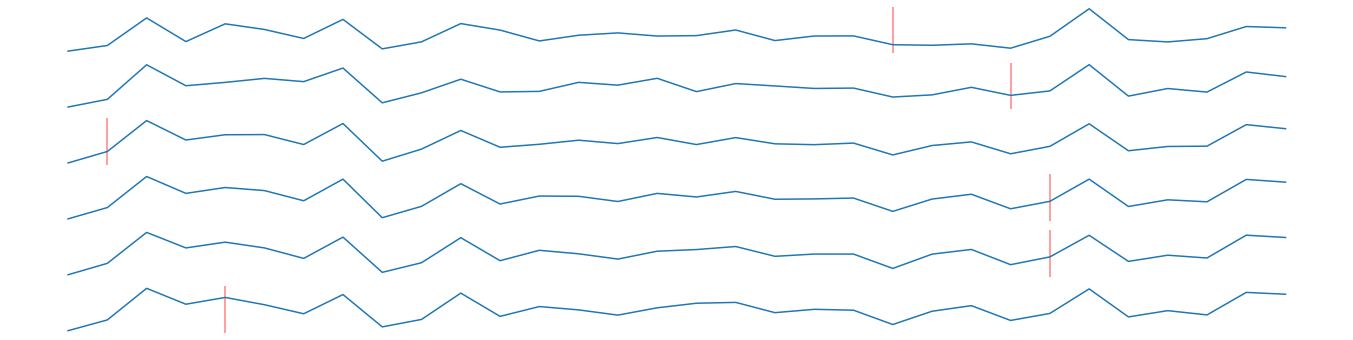

Training lstm ..
Rewards: [5.519, 5.708, 5.792, 5.517, 5.764]
lstm loss (epochs average): 0.00019488703674142016
NAS epoch 3
Epoch average accuracy (5 sequences): 0.63


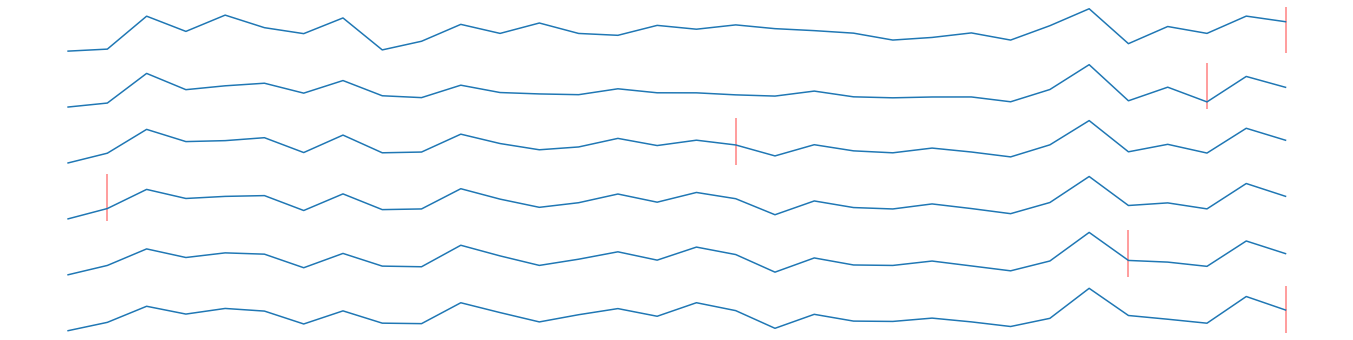

Training lstm ..
Rewards: [5.794, 5.516, 5.801, 5.522, 5.516]
lstm loss (epochs average): 6.25506352918137e-05
NAS epoch 4
Epoch average accuracy (5 sequences): 0.721


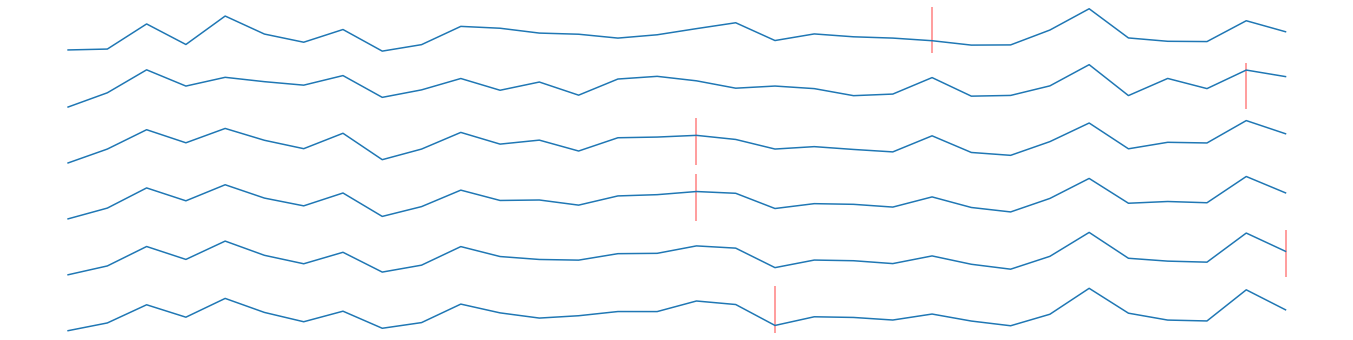

Training lstm ..
Rewards: [5.795, 5.795, 5.789, 5.712, 5.515]
lstm loss (epochs average): 4.693036839853448e-05
NAS epoch 5
Epoch average accuracy (5 sequences): 0.544


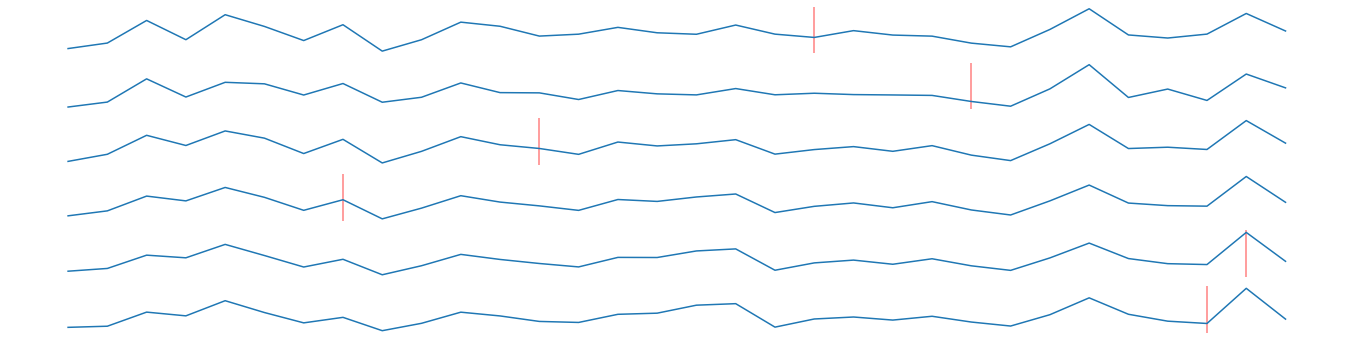

Training lstm ..
Rewards: [5.515, 5.516, 5.656, 5.517, 5.516]
lstm loss (epochs average): 1.812389459132646e-05
NAS epoch 6
Epoch average accuracy (5 sequences): 0.595


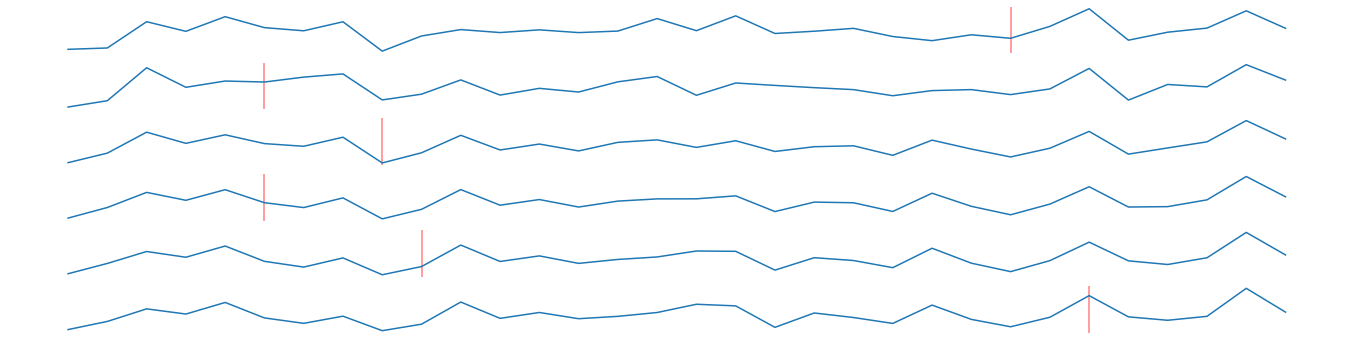

Training lstm ..
Rewards: [5.517, 5.517, 5.516, 5.804, 5.622]
lstm loss (epochs average): -4.2367104446383586e-05
NAS epoch 7
Epoch average accuracy (5 sequences): 0.672


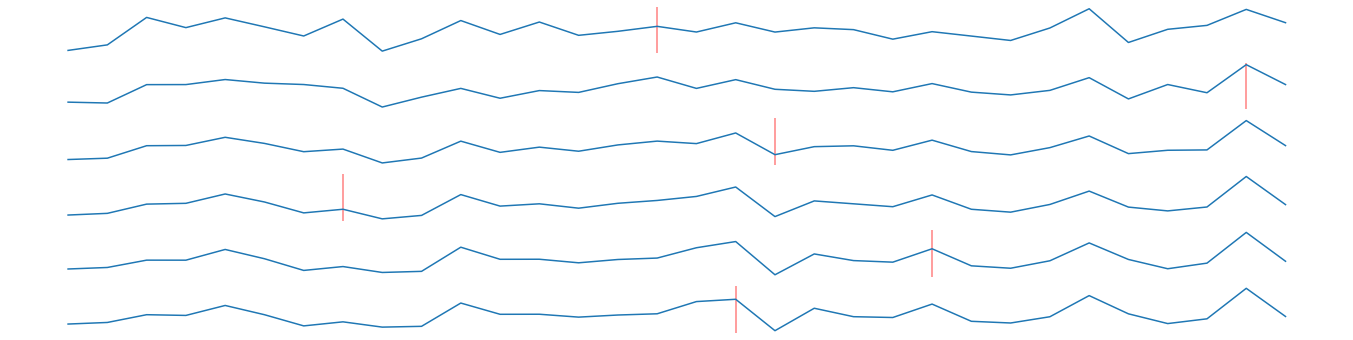

Training lstm ..
Rewards: [5.754, 5.517, 5.764, 5.515, 5.808]
lstm loss (epochs average): -0.00012024079421735223
NAS epoch 8
Epoch average accuracy (5 sequences): 0.653


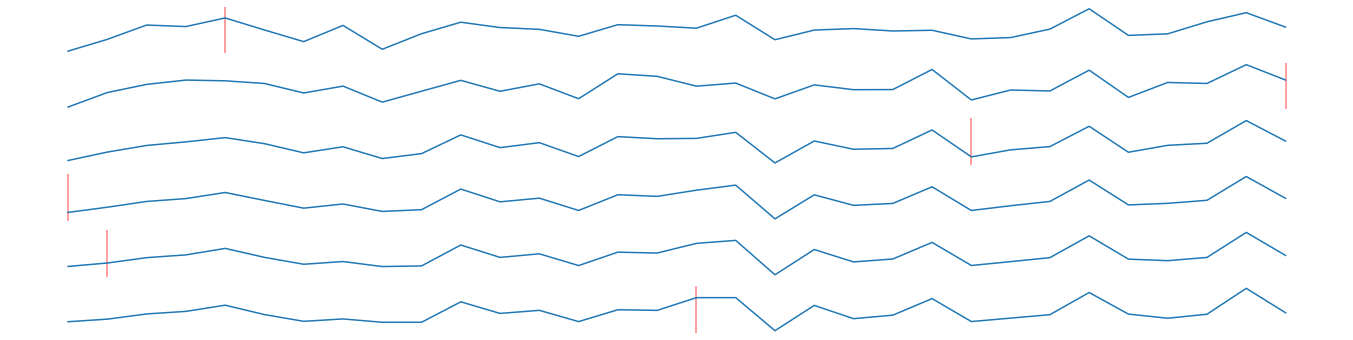

Training lstm ..
Rewards: [5.516, 5.773, 5.515, 5.768, 5.691]
lstm loss (epochs average): -0.0002754613269644324
NAS epoch 9
Epoch average accuracy (5 sequences): 0.726


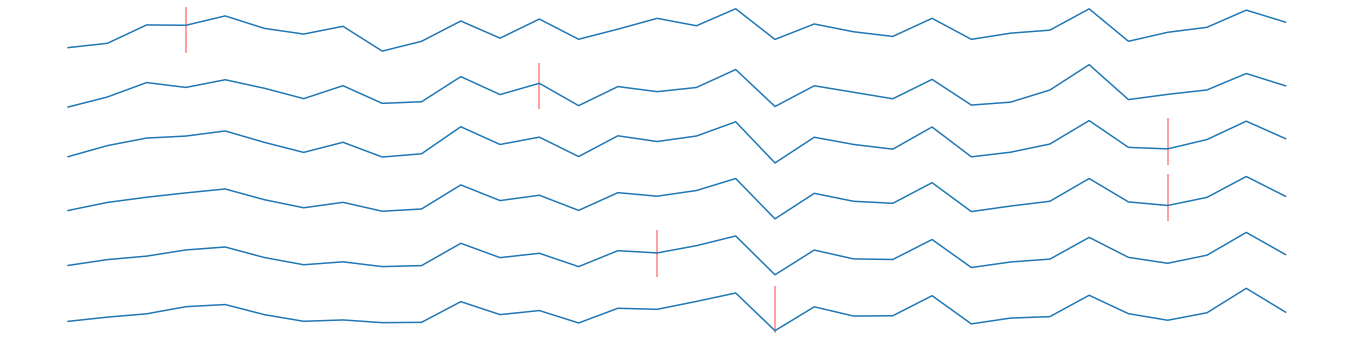

Training lstm ..
Rewards: [5.76, 5.814, 5.733, 5.799, 5.523]
lstm loss (epochs average): 0.000143599950774842
NAS epoch 10
Epoch average accuracy (5 sequences): 0.638


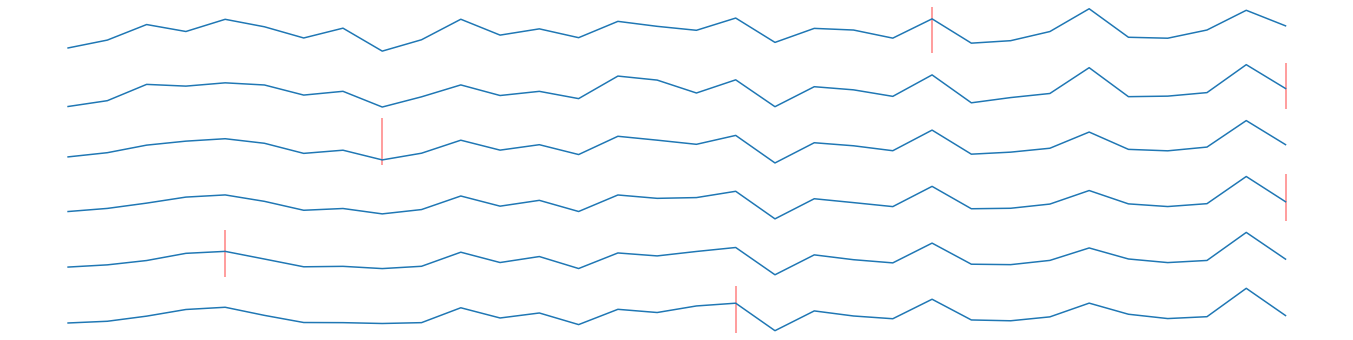

Training lstm ..
Rewards: [5.781, 5.532, 5.826, 5.534, 5.516]
lstm loss (epochs average): 0.0003001917107017249
NAS epoch 11
Epoch average accuracy (5 sequences): 0.686


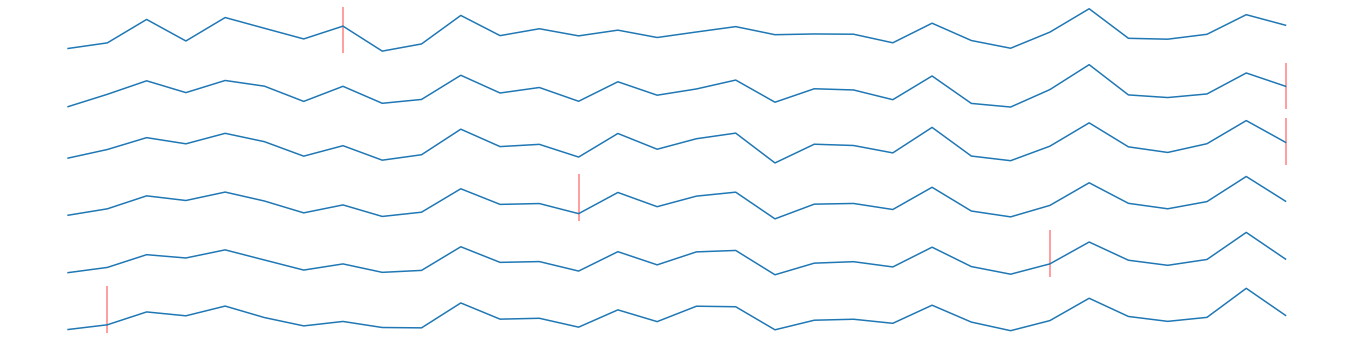

Training lstm ..
Rewards: [5.61, 5.805, 5.693, 5.801, 5.519]
lstm loss (epochs average): 0.00010262876656952358
NAS epoch 12
Epoch average accuracy (5 sequences): 0.572


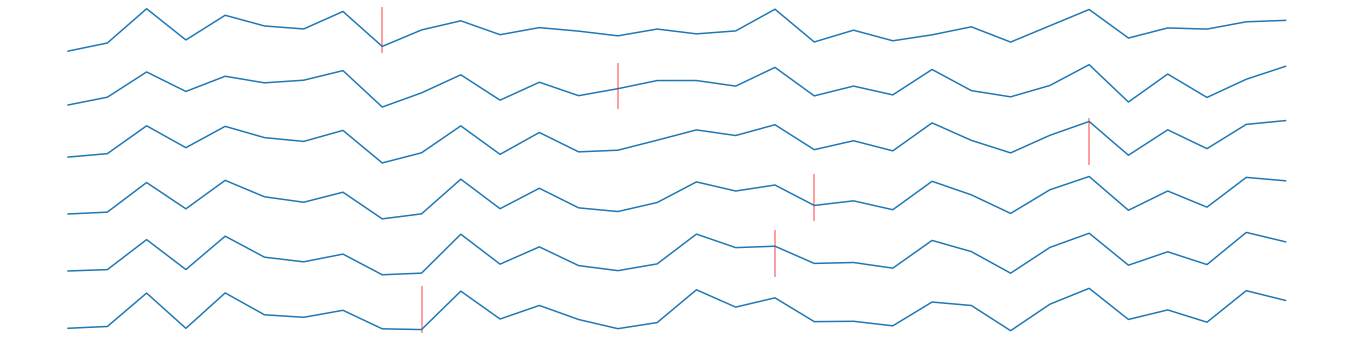

Training lstm ..
Rewards: [5.516, 5.516, 5.515, 5.516, 5.796]
lstm loss (epochs average): 2.5482382355335176e-05
NAS epoch 13
Epoch average accuracy (5 sequences): 0.682


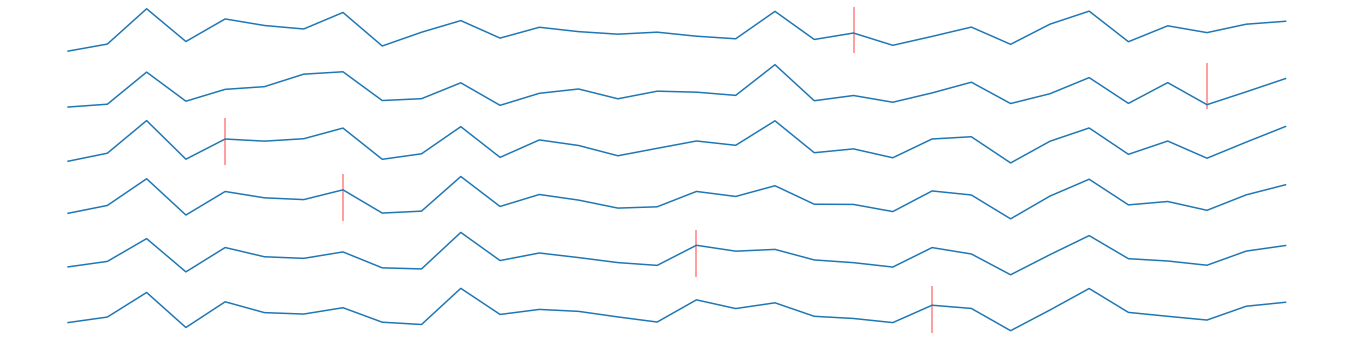

Training lstm ..
Rewards: [5.776, 5.785, 5.817, 5.517, 5.516]
lstm loss (epochs average): -5.964531337099288e-05
NAS epoch 14
Epoch average accuracy (5 sequences): 0.702


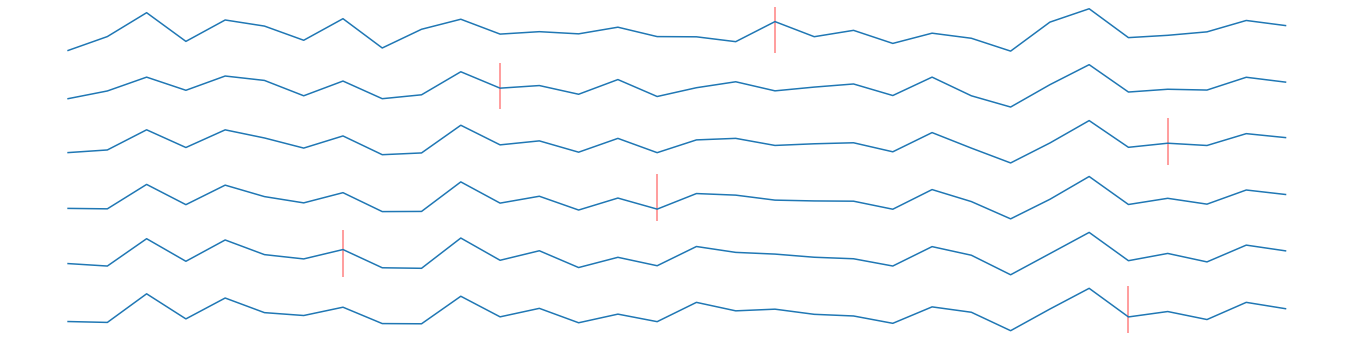

Training lstm ..
Rewards: [5.75, 5.515, 5.668, 5.787, 5.792]
lstm loss (epochs average): -1.7496290563911998e-05
NAS epoch 15
Epoch average accuracy (5 sequences): 0.712


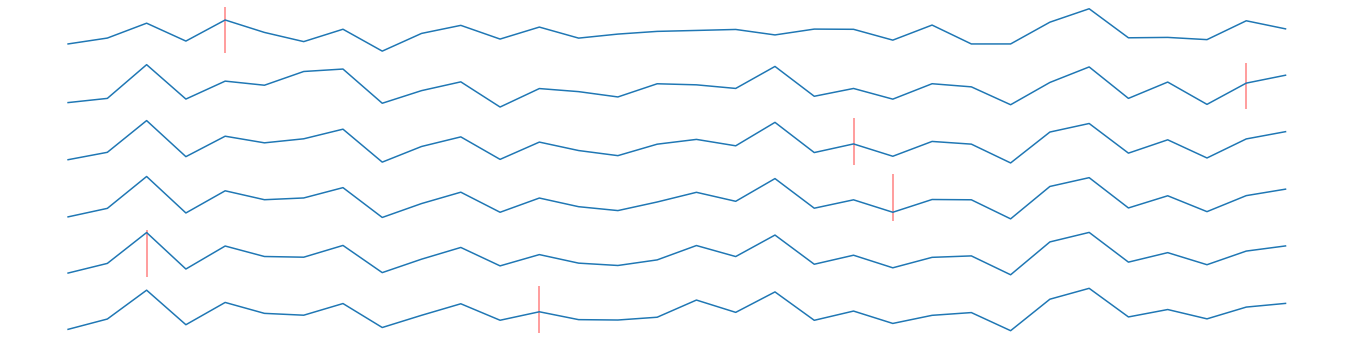

Training lstm ..
Rewards: [5.515, 5.709, 5.797, 5.794, 5.744]
lstm loss (epochs average): 0.00010307965550282461
NAS epoch 16
Epoch average accuracy (5 sequences): 0.671


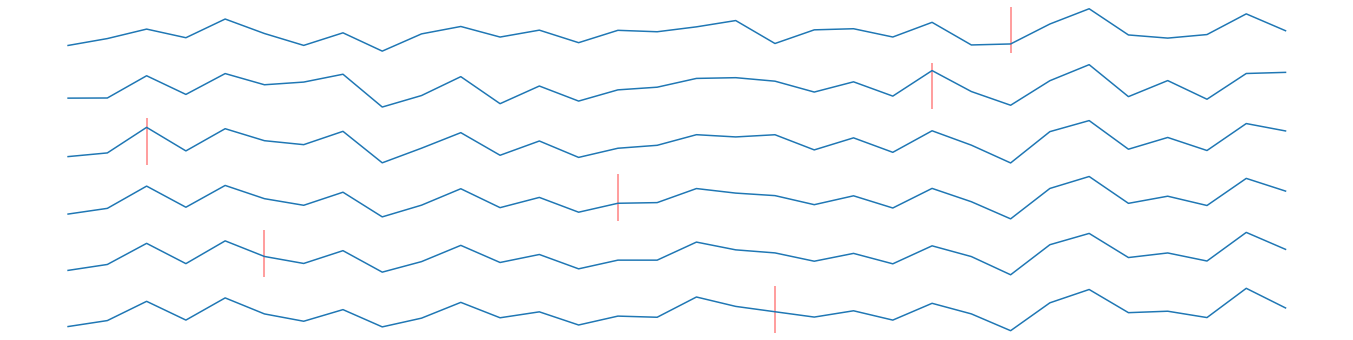

Training lstm ..
Rewards: [5.516, 5.515, 5.732, 5.791, 5.801]
lstm loss (epochs average): 1.0201118932684494e-05
NAS epoch 17
Epoch average accuracy (5 sequences): 0.602


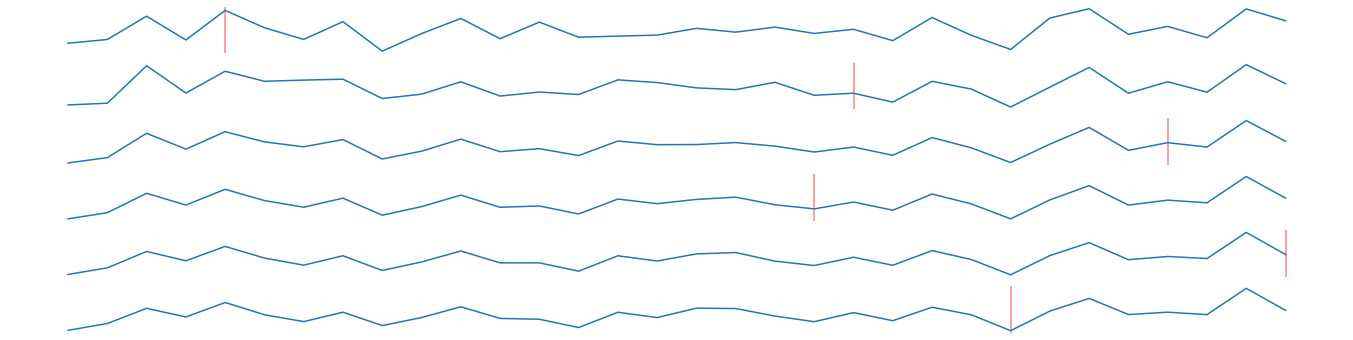

Training lstm ..
Rewards: [5.515, 5.667, 5.551, 5.517, 5.76]
lstm loss (epochs average): 3.709468678181338e-05
NAS epoch 18
Epoch average accuracy (5 sequences): 0.681


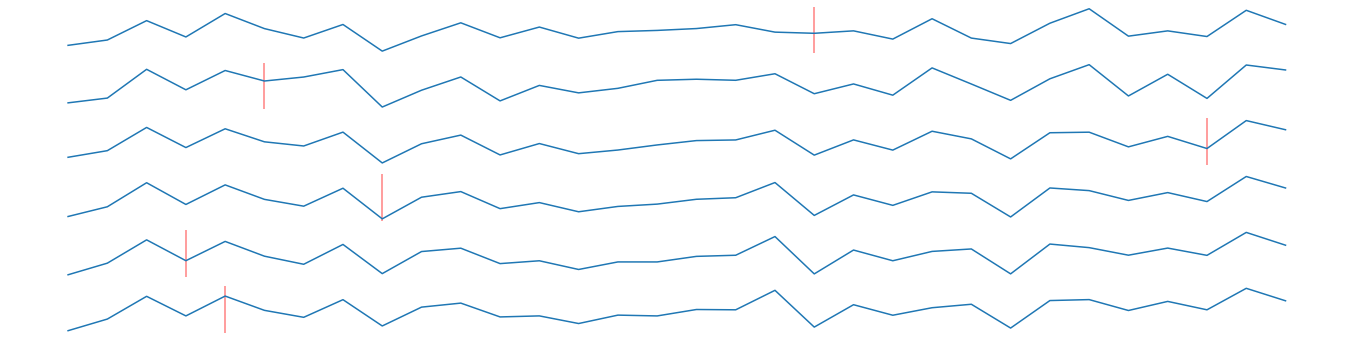

Training lstm ..
Rewards: [5.516, 5.803, 5.796, 5.772, 5.516]
lstm loss (epochs average): 7.79039566936035e-05
NAS epoch 19
Epoch average accuracy (5 sequences): 0.64


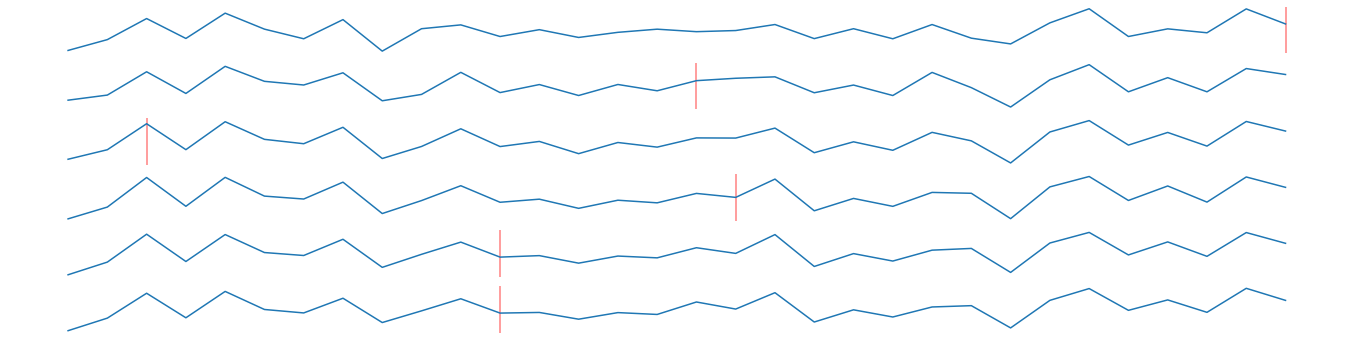

Training lstm ..
Rewards: [5.717, 5.518, 5.774, 5.674, 5.516]
lstm loss (epochs average): 4.3711834507575986e-07
NAS epoch 20
Epoch average accuracy (5 sequences): 0.716


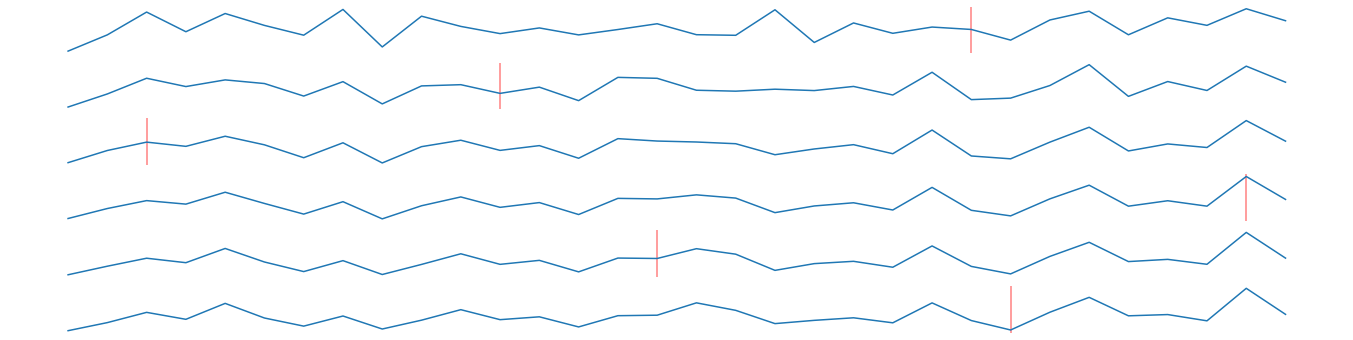

Training lstm ..
Rewards: [5.797, 5.798, 5.68, 5.516, 5.789]
lstm loss (epochs average): 6.270095413540844e-06
NAS epoch 21
Epoch average accuracy (5 sequences): 0.627


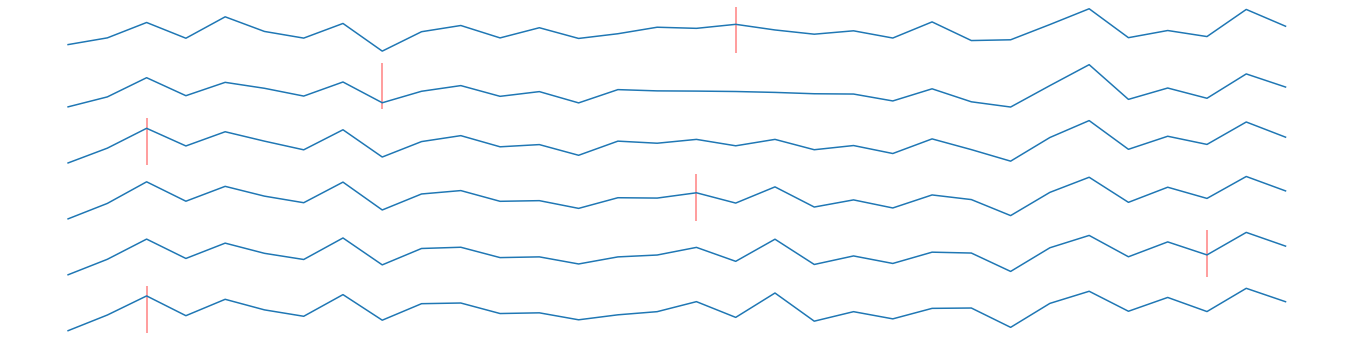

Training lstm ..
Rewards: [5.797, 5.516, 5.793, 5.515, 5.516]
lstm loss (epochs average): -1.991614055896207e-07
NAS epoch 22
Epoch average accuracy (5 sequences): 0.728


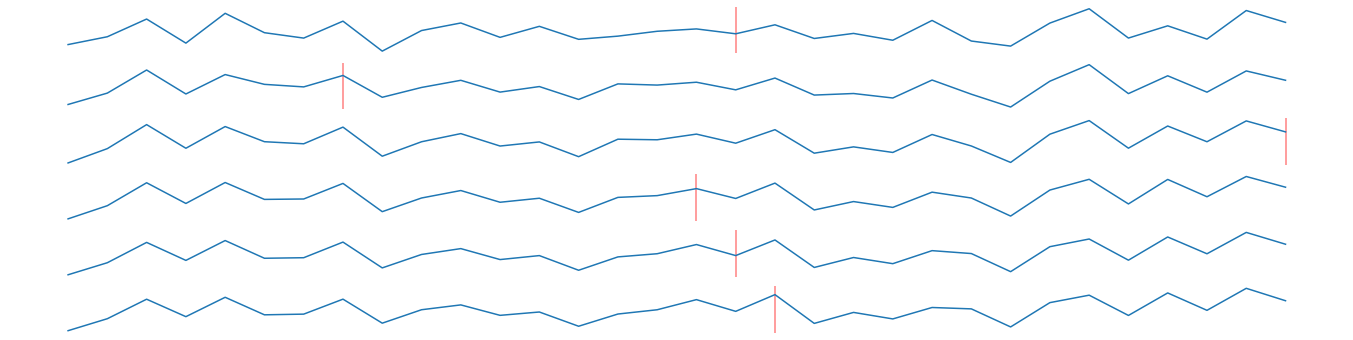

Training lstm ..
Rewards: [5.516, 5.771, 5.763, 5.797, 5.792]
lstm loss (epochs average): -2.335170330525216e-05
NAS epoch 23
Epoch average accuracy (5 sequences): 0.632


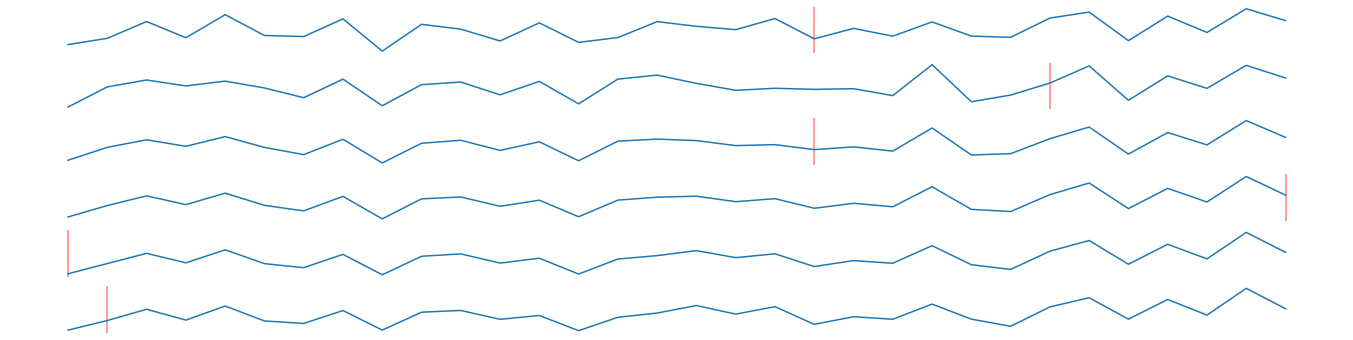

Training lstm ..
Rewards: [5.809, 5.799, 5.516, 5.517, 5.517]
lstm loss (epochs average): 4.787983635878845e-05
NAS epoch 24
Epoch average accuracy (5 sequences): 0.618


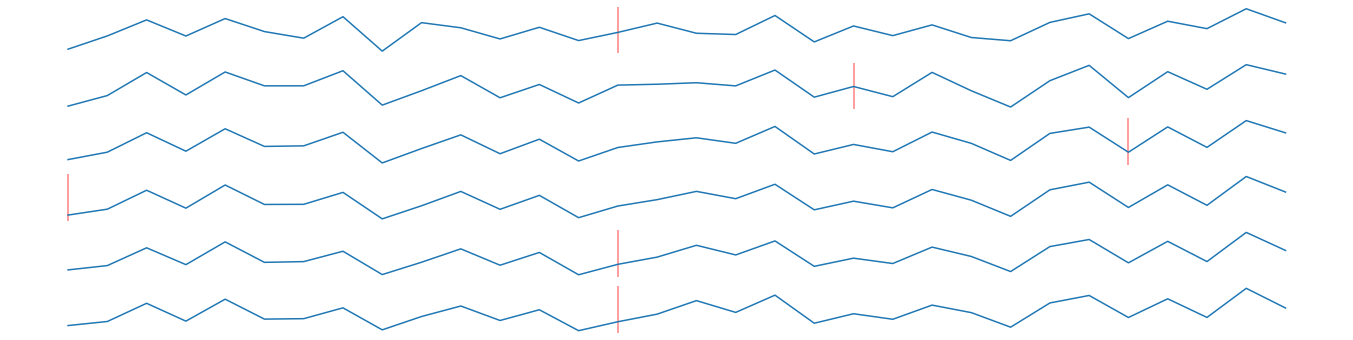

Training lstm ..
Rewards: [5.782, 5.515, 5.762, 5.515, 5.516]
lstm loss (epochs average): 4.295478049698431e-05
NAS epoch 25
Epoch average accuracy (5 sequences): 0.563


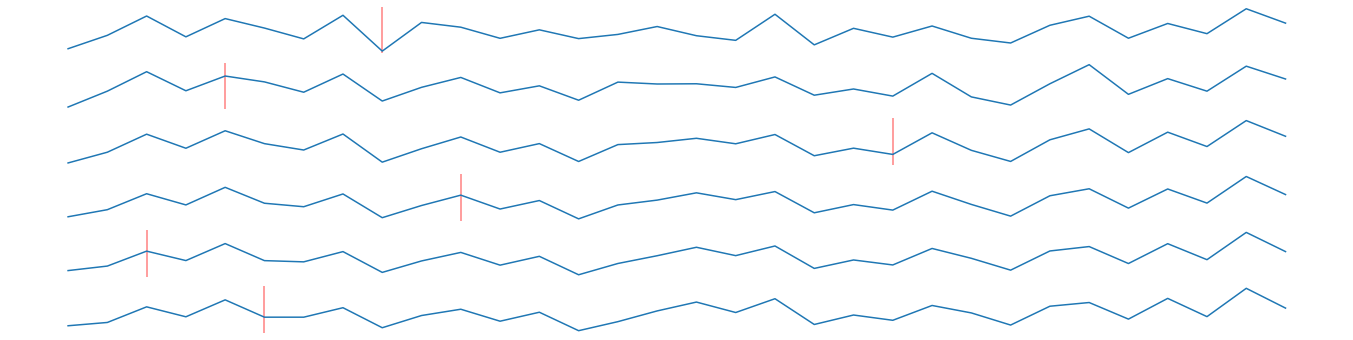

Training lstm ..
Rewards: [5.751, 5.517, 5.516, 5.516, 5.517]
lstm loss (epochs average): -2.6839848601412086e-05
NAS epoch 26
Epoch average accuracy (5 sequences): 0.692


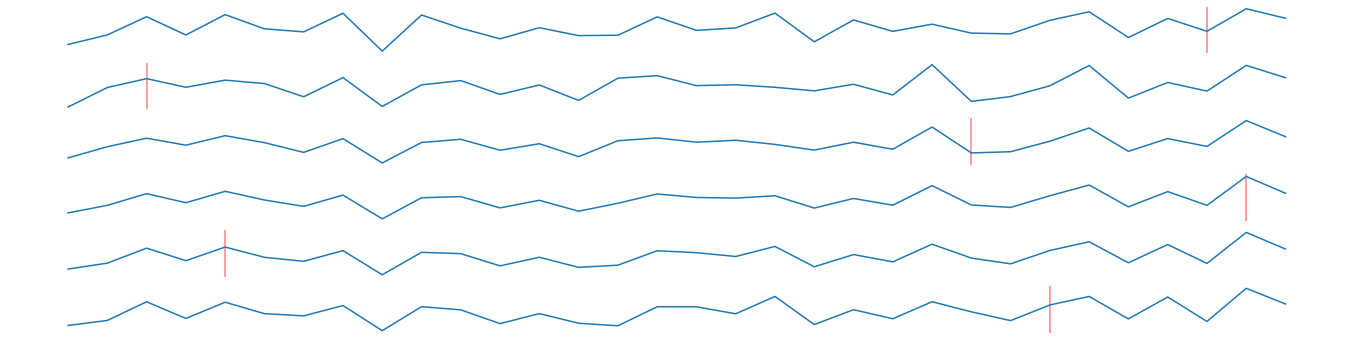

Training lstm ..
Rewards: [5.752, 5.774, 5.57, 5.557, 5.806]
lstm loss (epochs average): -0.0004589654048743341
NAS epoch 27
Epoch average accuracy (5 sequences): 0.68


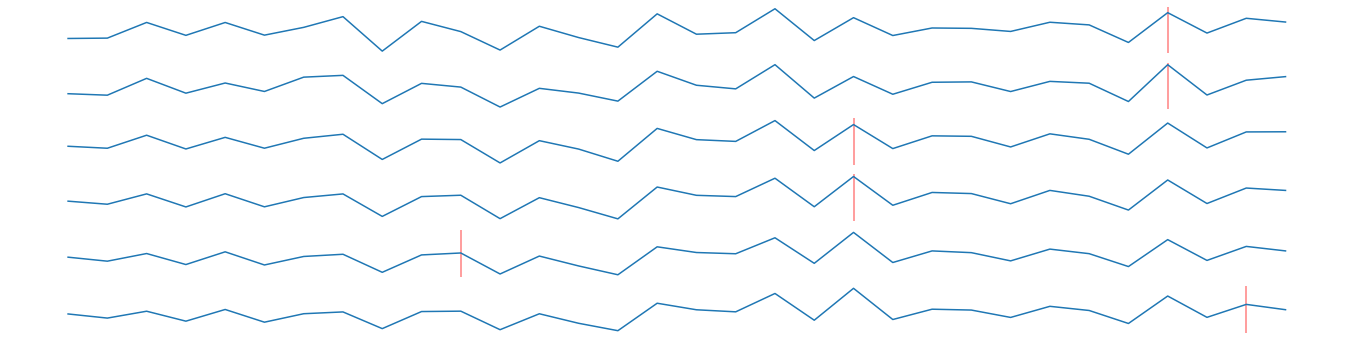

Training lstm ..
Rewards: [5.789, 5.811, 5.769, 5.516, 5.515]
lstm loss (epochs average): 0.0006167942573256369
NAS epoch 28
Epoch average accuracy (5 sequences): 0.573


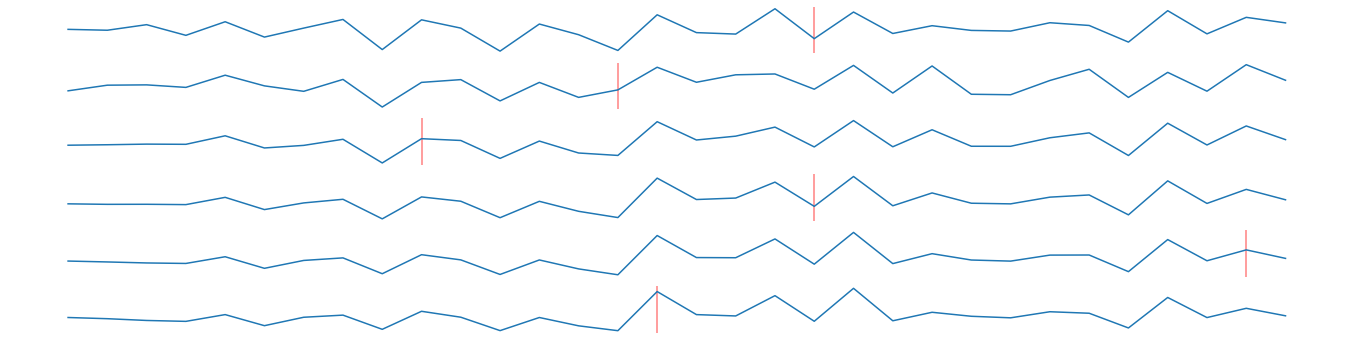

Training lstm ..
Rewards: [5.802, 5.515, 5.515, 5.515, 5.516]
lstm loss (epochs average): 0.00028774863665148587
NAS epoch 29
Epoch average accuracy (5 sequences): 0.603


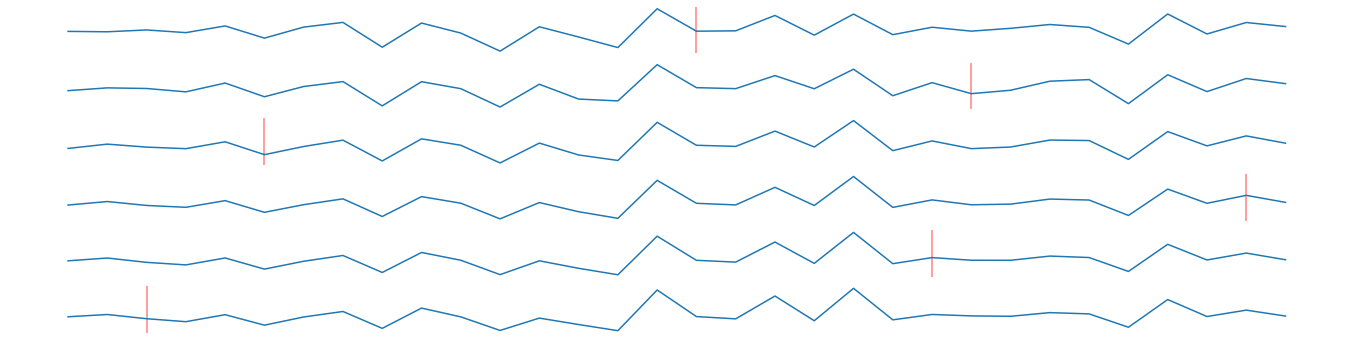

Training lstm ..
Rewards: [5.516, 5.525, 5.643, 5.814, 5.516]
lstm loss (epochs average): -3.815526008565939e-05
NAS epoch 30
Epoch average accuracy (5 sequences): 0.632


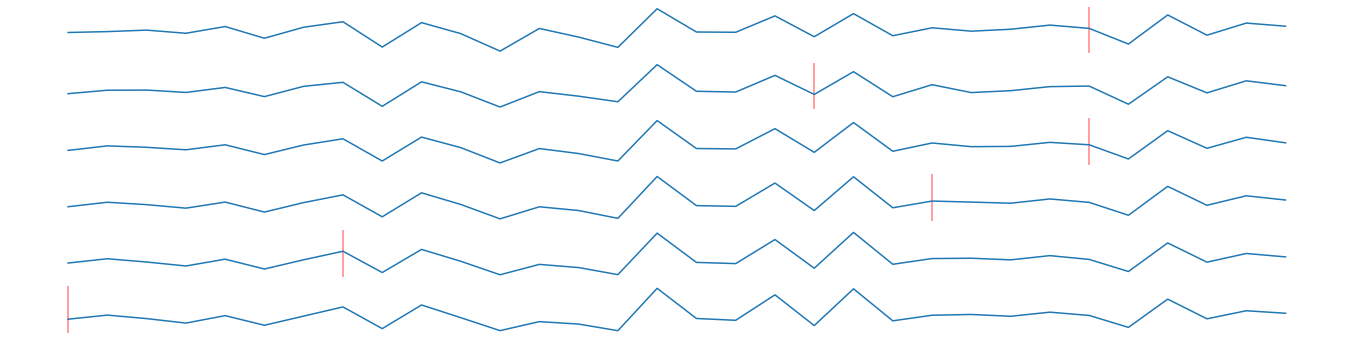

Training lstm ..
Rewards: [5.516, 5.756, 5.777, 5.515, 5.594]
lstm loss (epochs average): 2.4198944174713688e-05
NAS epoch 31
Epoch average accuracy (5 sequences): 0.602


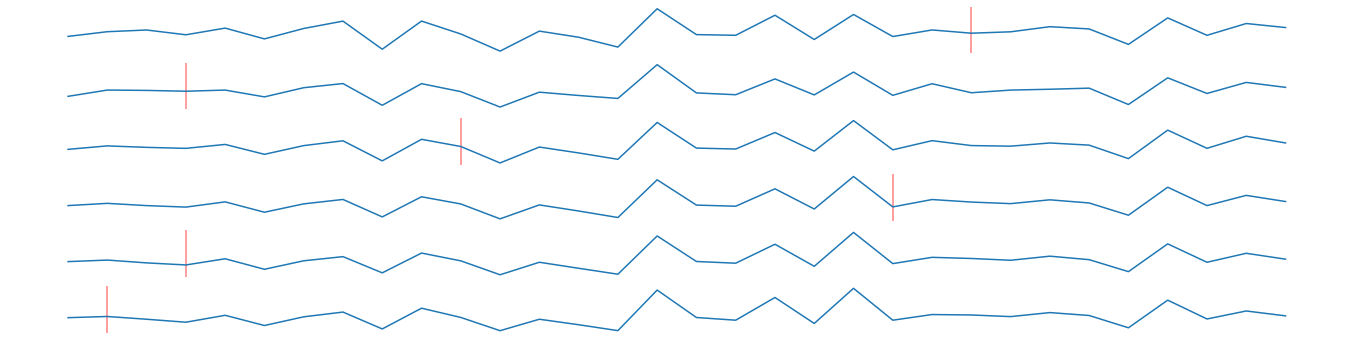

Training lstm ..
Rewards: [5.523, 5.53, 5.516, 5.67, 5.769]
lstm loss (epochs average): 0.0002325585587641399
NAS epoch 32
Epoch average accuracy (5 sequences): 0.639


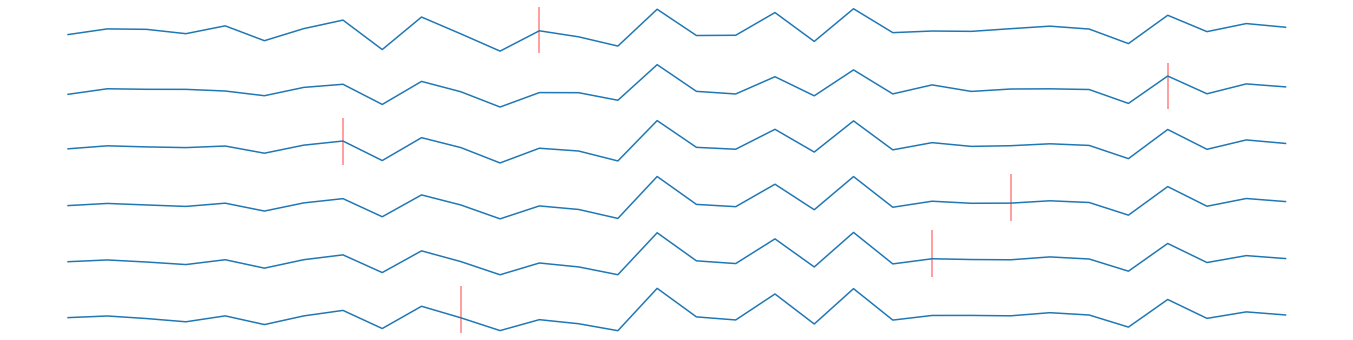

Training lstm ..
Rewards: [5.831, 5.517, 5.533, 5.517, 5.799]
lstm loss (epochs average): 3.231166238037986e-05
NAS epoch 33
Epoch average accuracy (5 sequences): 0.633


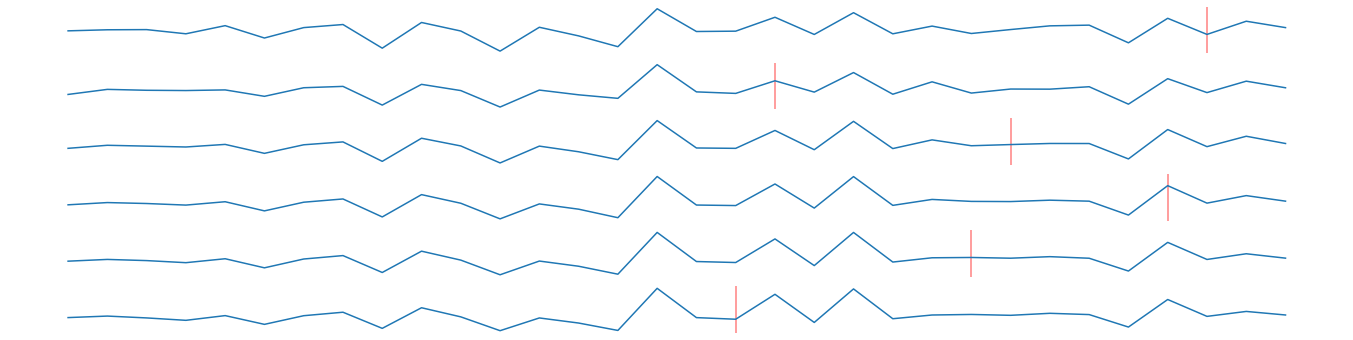

Training lstm ..
Rewards: [5.564, 5.516, 5.516, 5.77, 5.801]
lstm loss (epochs average): 0.00031059867885119274
NAS epoch 34
Epoch average accuracy (5 sequences): 0.745


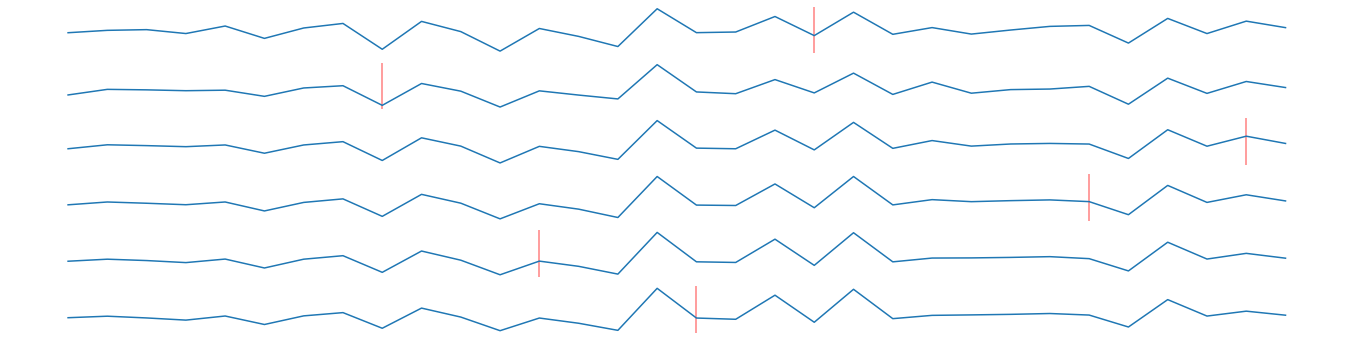

Training lstm ..
Rewards: [5.517, 5.777, 5.802, 5.814, 5.817]
lstm loss (epochs average): -1.2401151764152019e-05
NAS epoch 35
Epoch average accuracy (5 sequences): 0.549


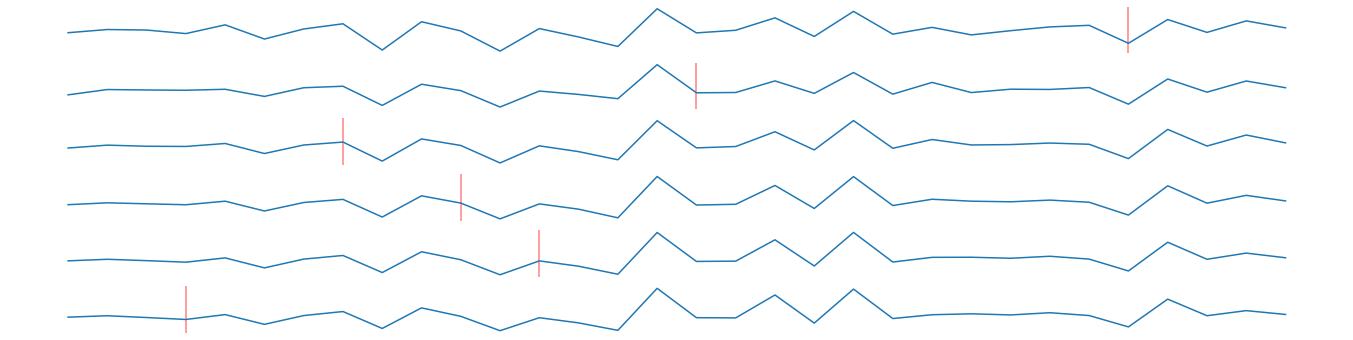

Training lstm ..
Rewards: [5.641, 5.521, 5.55, 5.519, 5.516]
lstm loss (epochs average): 4.8803010940901004e-05
NAS epoch 36
Epoch average accuracy (5 sequences): 0.682


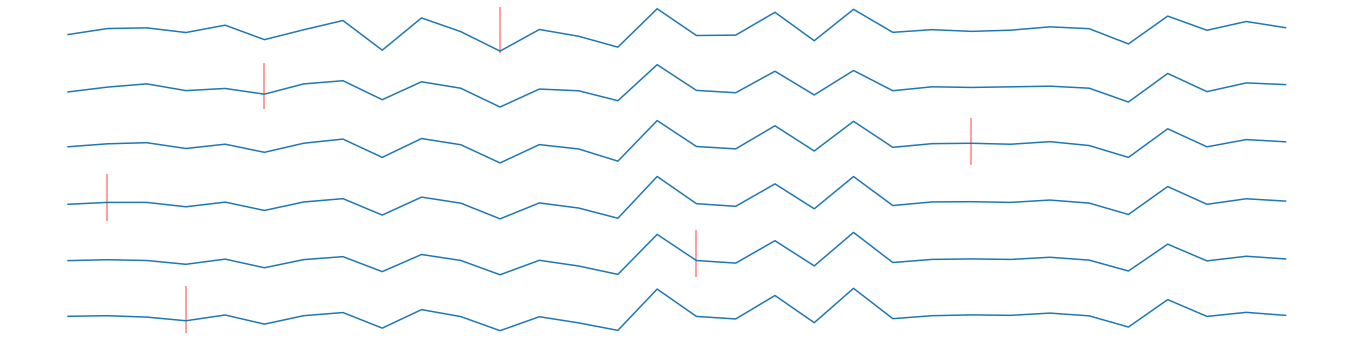

Training lstm ..
Rewards: [5.637, 5.792, 5.7, 5.767, 5.515]
lstm loss (epochs average): -2.8587352346676198e-05
NAS epoch 37
Epoch average accuracy (5 sequences): 0.617


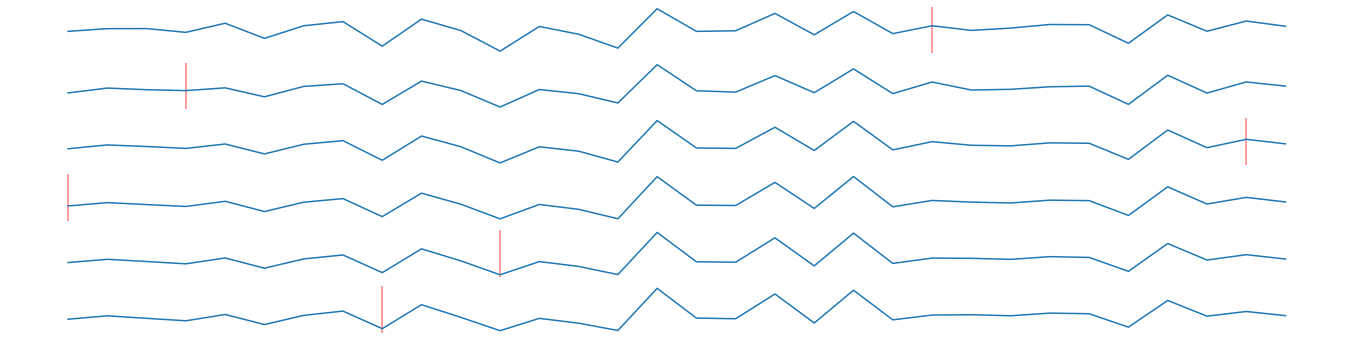

Training lstm ..
Rewards: [5.516, 5.795, 5.736, 5.518, 5.519]
lstm loss (epochs average): -6.39702266198583e-05
NAS epoch 38
Epoch average accuracy (5 sequences): 0.635


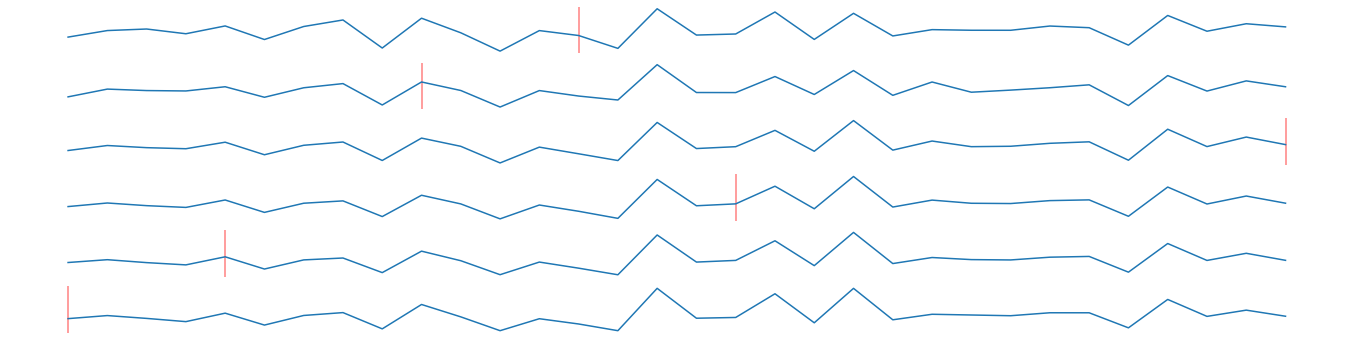

Training lstm ..
Rewards: [5.811, 5.517, 5.565, 5.767, 5.515]
lstm loss (epochs average): 7.583052217796649e-05
NAS epoch 39
Epoch average accuracy (5 sequences): 0.673


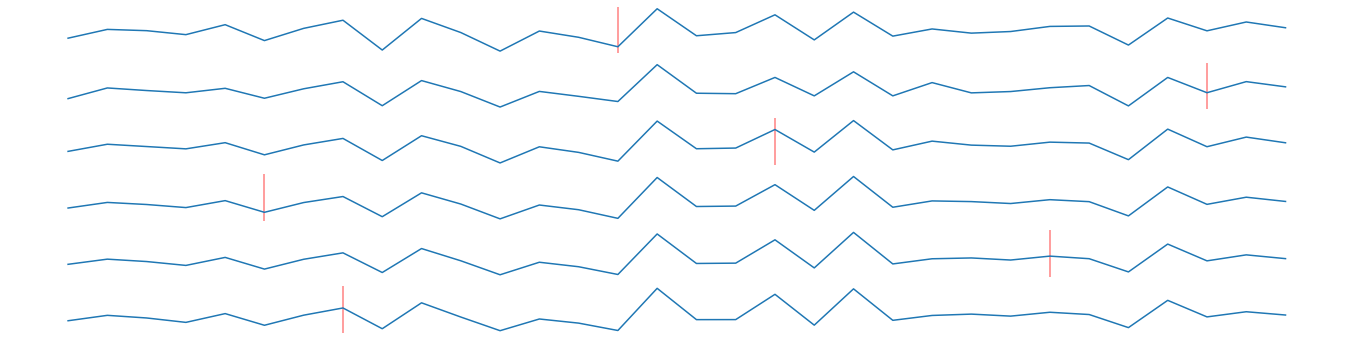

Training lstm ..
Rewards: [5.516, 5.516, 5.766, 5.772, 5.793]
lstm loss (epochs average): 4.209792348319752e-05
NAS epoch 40
Epoch average accuracy (5 sequences): 0.629


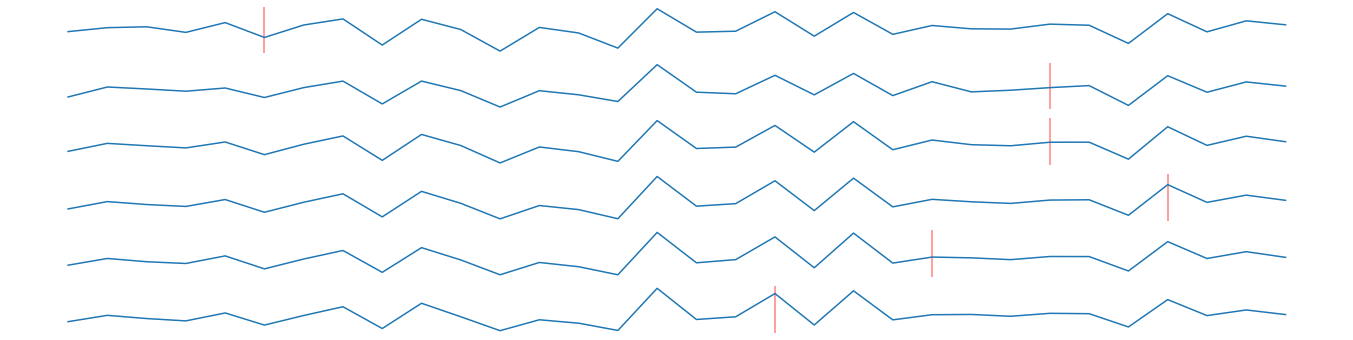

Training lstm ..
Rewards: [5.516, 5.516, 5.516, 5.792, 5.805]
lstm loss (epochs average): 9.455918282696985e-05
NAS epoch 41
Epoch average accuracy (5 sequences): 0.584


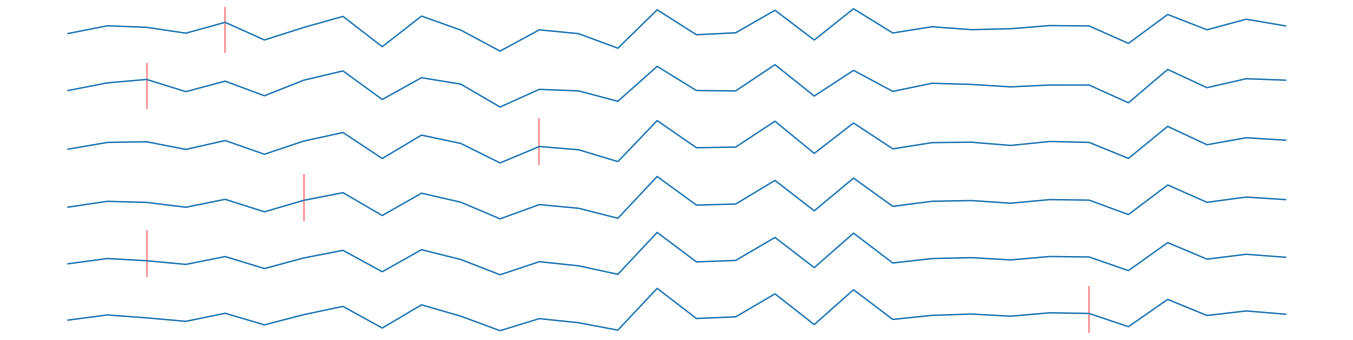

Training lstm ..
Rewards: [5.58, 5.516, 5.517, 5.515, 5.79]
lstm loss (epochs average): 2.774318481613136e-05
NAS epoch 42
Epoch average accuracy (5 sequences): 0.671


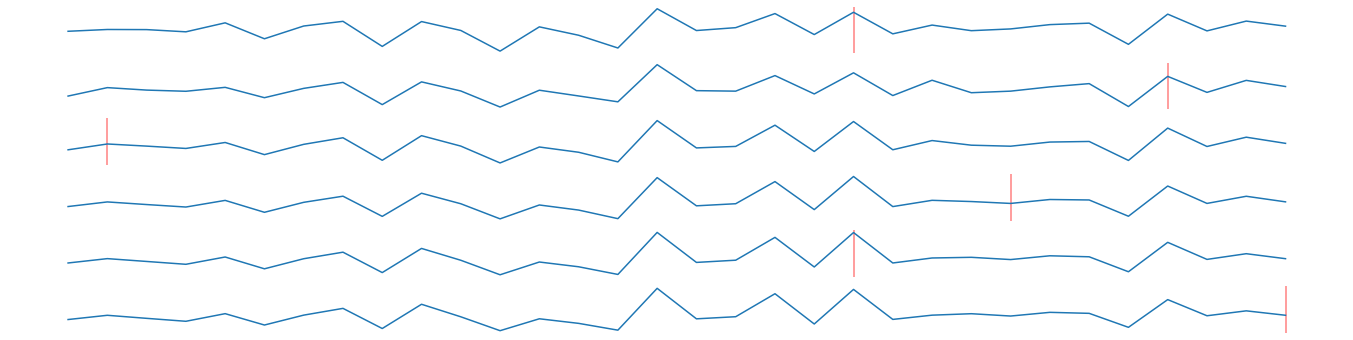

Training lstm ..
Rewards: [5.746, 5.52, 5.797, 5.774, 5.517]
lstm loss (epochs average): 3.7778010039346555e-05
NAS epoch 43
Epoch average accuracy (5 sequences): 0.708


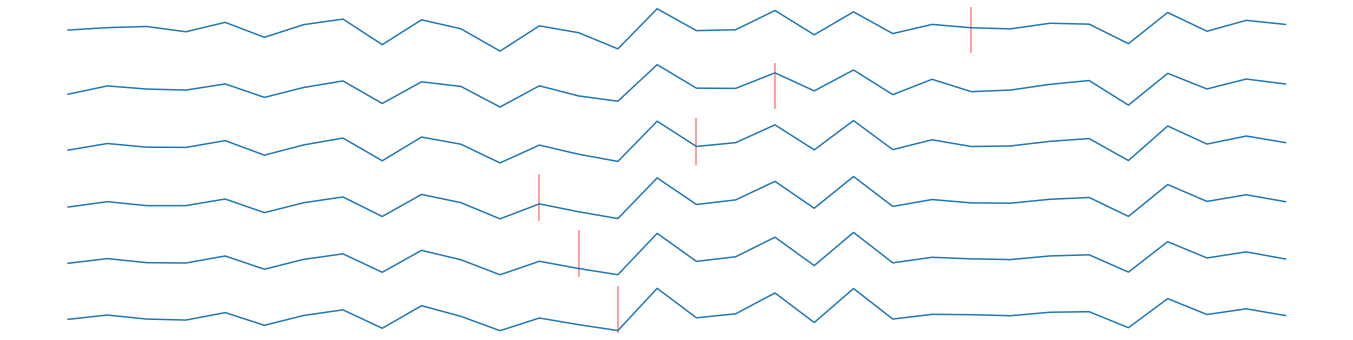

Training lstm ..
Rewards: [5.69, 5.802, 5.797, 5.525, 5.728]
lstm loss (epochs average): -1.326999685602459e-05
NAS epoch 44
Epoch average accuracy (5 sequences): 0.711


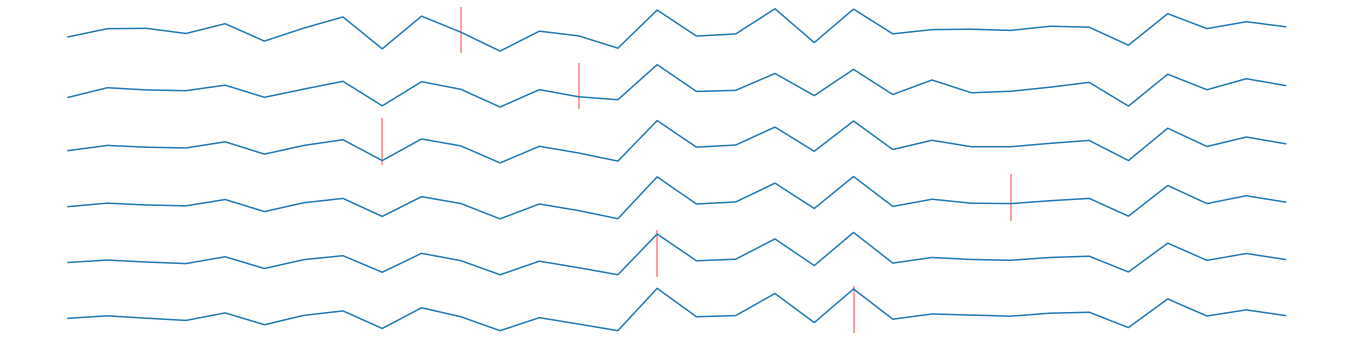

Training lstm ..
Rewards: [5.787, 5.772, 5.695, 5.519, 5.781]
lstm loss (epochs average): 0.00013385808591692694
NAS epoch 45
Epoch average accuracy (5 sequences): 0.567


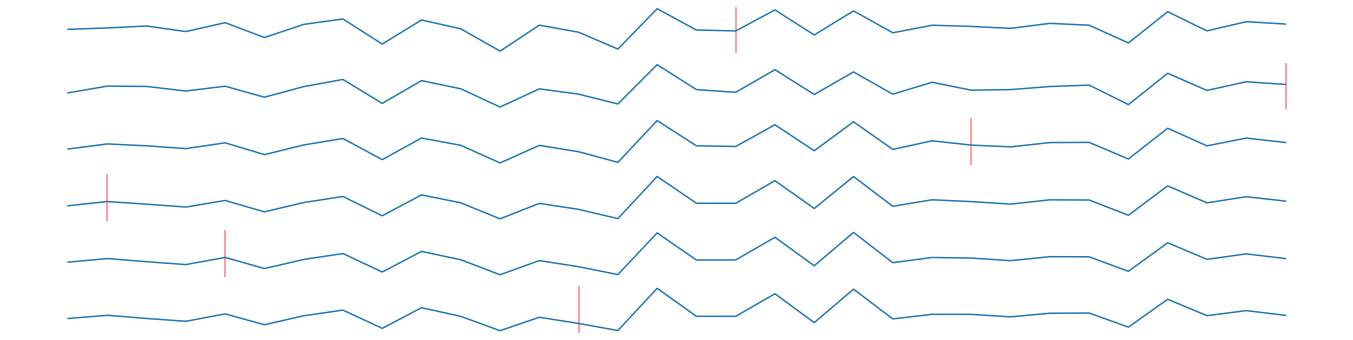

Training lstm ..
Rewards: [5.772, 5.517, 5.516, 5.515, 5.517]
lstm loss (epochs average): -0.0002008610914572273
NAS epoch 46
Epoch average accuracy (5 sequences): 0.557


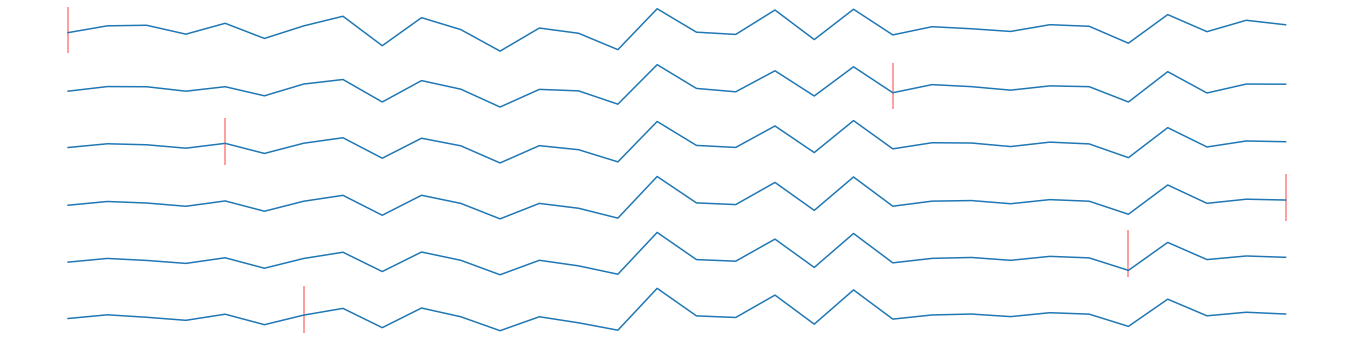

Training lstm ..
Rewards: [5.516, 5.516, 5.721, 5.516, 5.516]
lstm loss (epochs average): -3.5084337923763087e-07
NAS epoch 47
Epoch average accuracy (5 sequences): 0.579


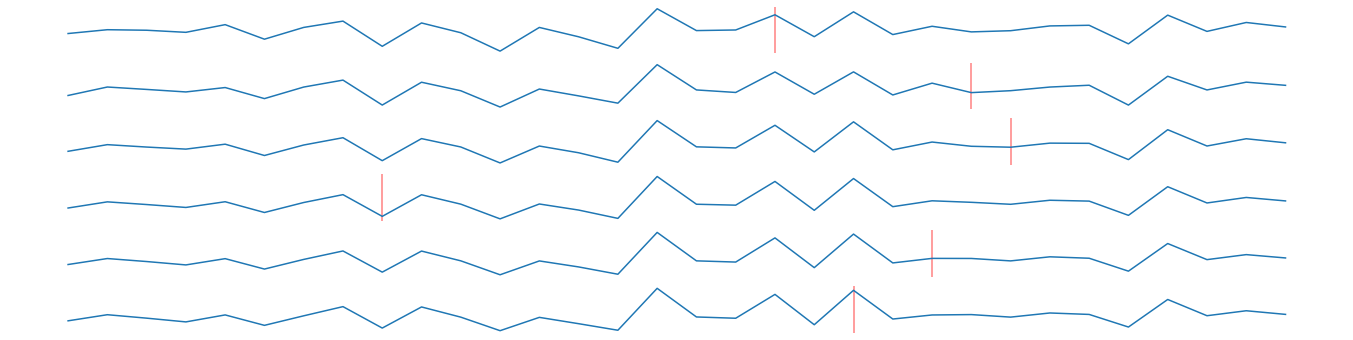

Training lstm ..
Rewards: [5.621, 5.516, 5.515, 5.727, 5.516]
lstm loss (epochs average): 4.209928350817904e-05
NAS epoch 48
Epoch average accuracy (5 sequences): 0.638


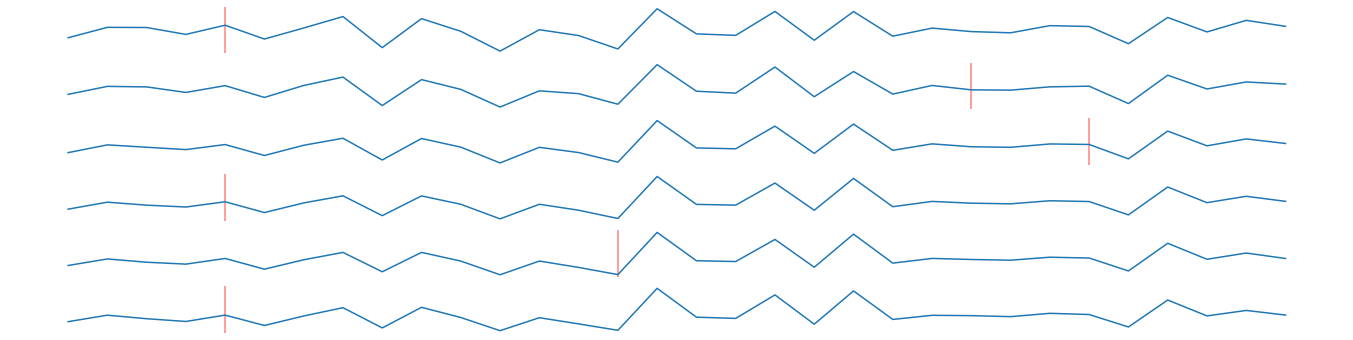

Training lstm ..
Rewards: [5.697, 5.515, 5.773, 5.688, 5.516]
lstm loss (epochs average): -4.126725065134451e-05
NAS epoch 49
Epoch average accuracy (5 sequences): 0.704


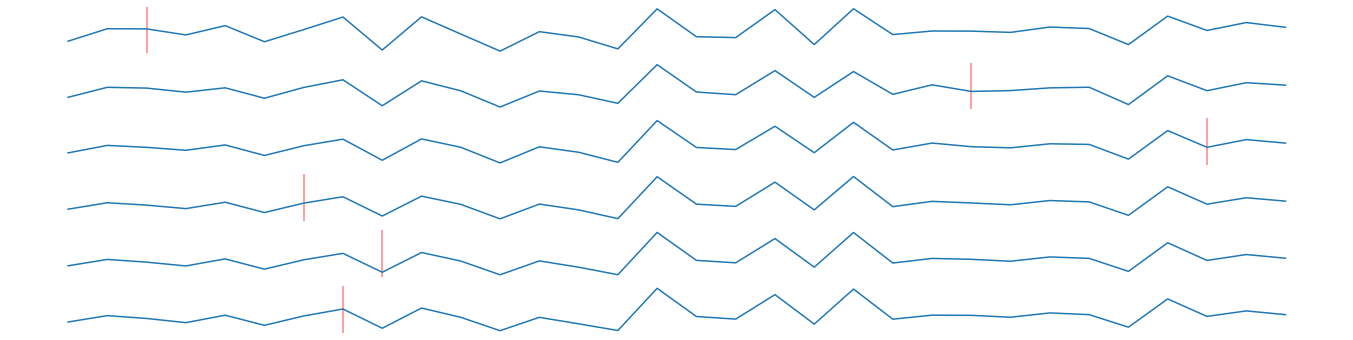

Training lstm ..
Rewards: [5.776, 5.515, 5.791, 5.645, 5.795]
lstm loss (epochs average): 7.816587913112016e-05
NAS epoch 50
Epoch average accuracy (5 sequences): 0.578


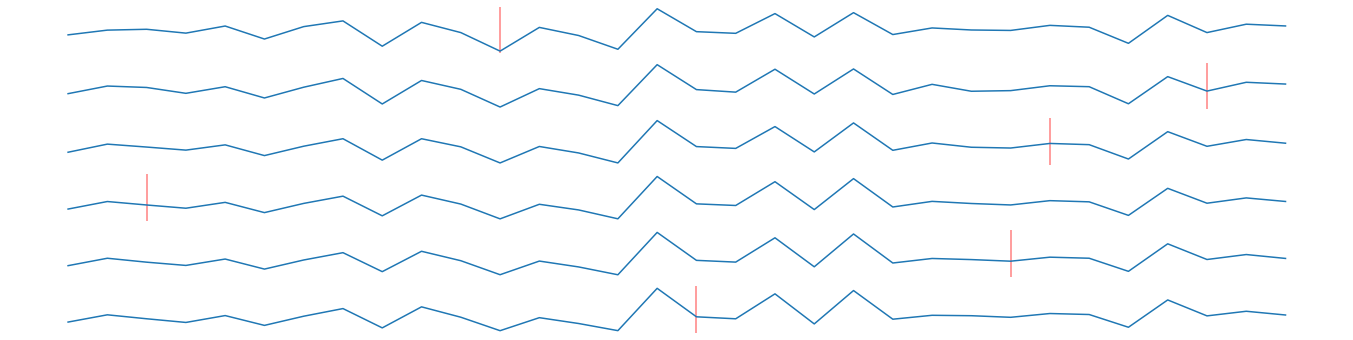

Training lstm ..
Rewards: [5.515, 5.518, 5.517, 5.542, 5.796]
lstm loss (epochs average): 0.0001652761320656282
NAS epoch 51
Epoch average accuracy (5 sequences): 0.622


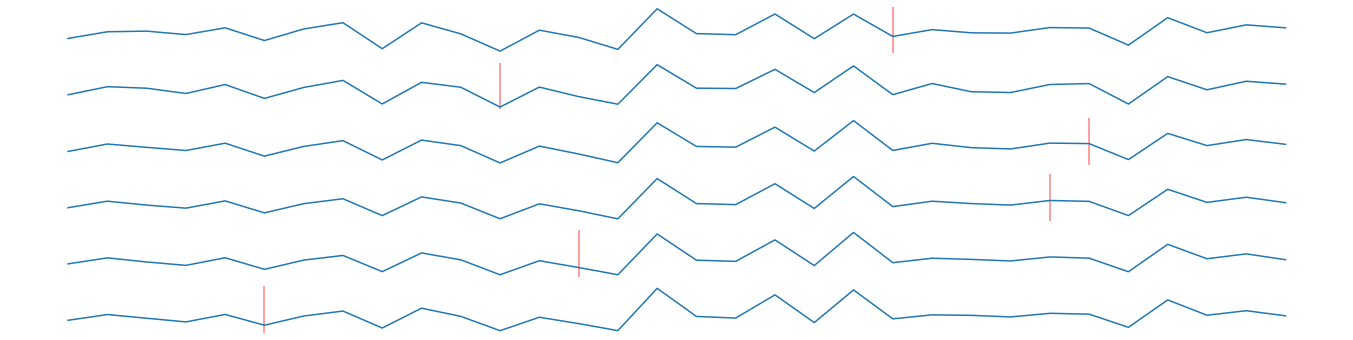

Training lstm ..
Rewards: [5.516, 5.632, 5.787, 5.517, 5.656]
lstm loss (epochs average): -1.4223490296672026e-05
NAS epoch 52
Epoch average accuracy (5 sequences): 0.57


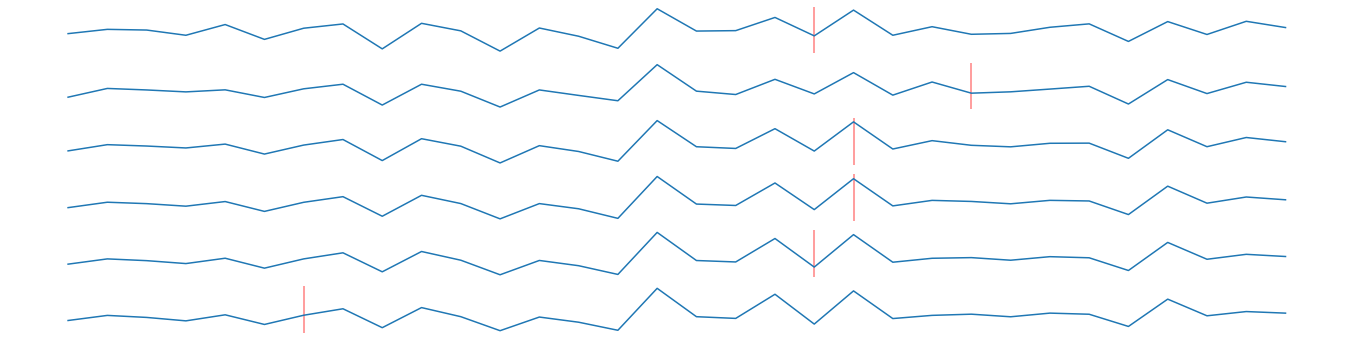

Training lstm ..
Rewards: [5.781, 5.515, 5.519, 5.516, 5.518]
lstm loss (epochs average): 9.71810300143261e-06
NAS epoch 53
Epoch average accuracy (5 sequences): 0.663


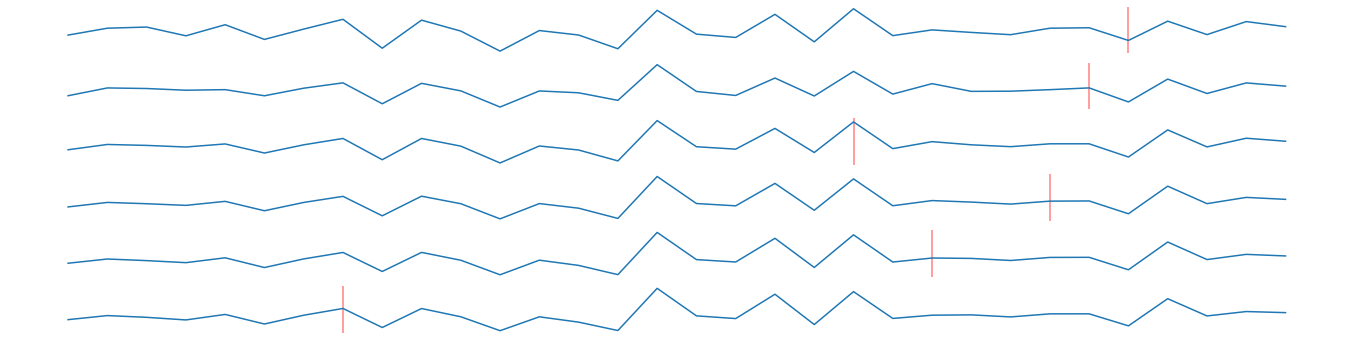

Training lstm ..
Rewards: [5.517, 5.791, 5.608, 5.624, 5.776]
lstm loss (epochs average): 0.00018077149559303507
NAS epoch 54
Epoch average accuracy (5 sequences): 0.527


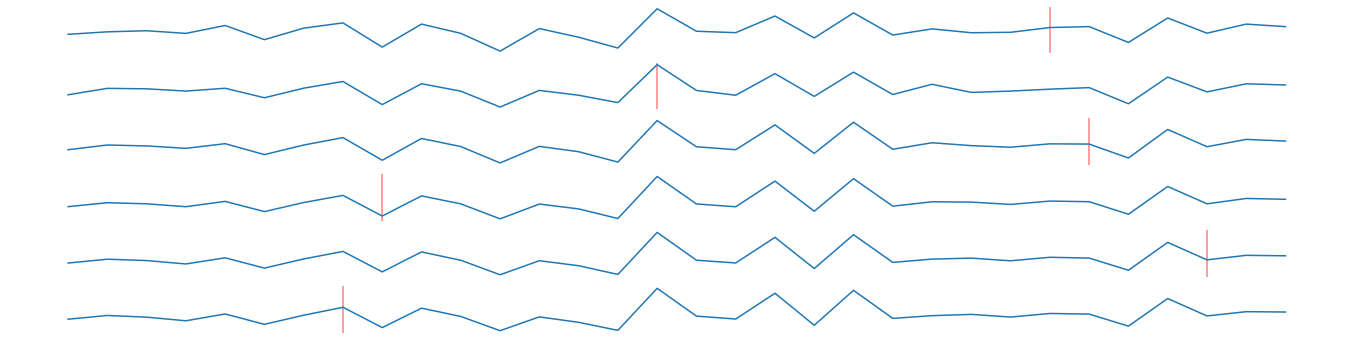

Training lstm ..
Rewards: [5.52, 5.525, 5.516, 5.516, 5.559]
lstm loss (epochs average): -5.845294589335026e-05
NAS epoch 55
Epoch average accuracy (5 sequences): 0.571


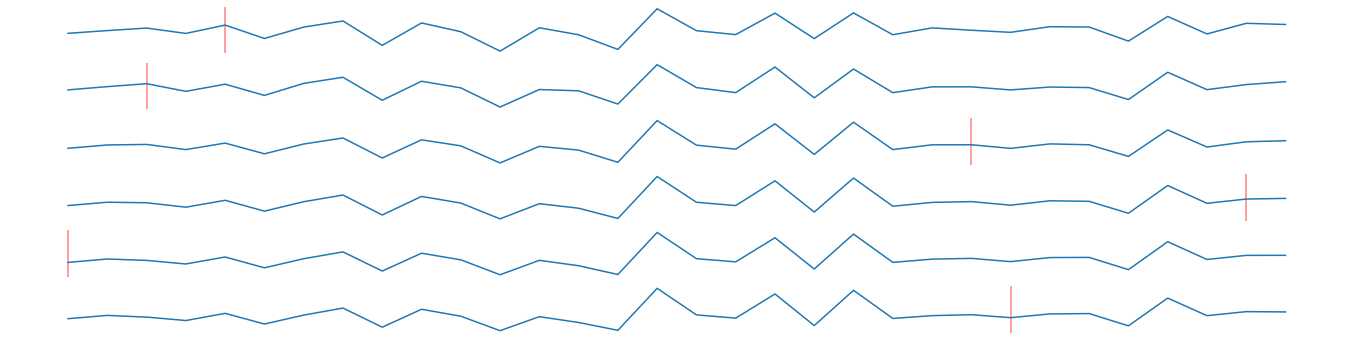

Training lstm ..
Rewards: [5.522, 5.517, 5.784, 5.515, 5.517]
lstm loss (epochs average): 8.955469189686482e-05
NAS epoch 56
Epoch average accuracy (5 sequences): 0.578


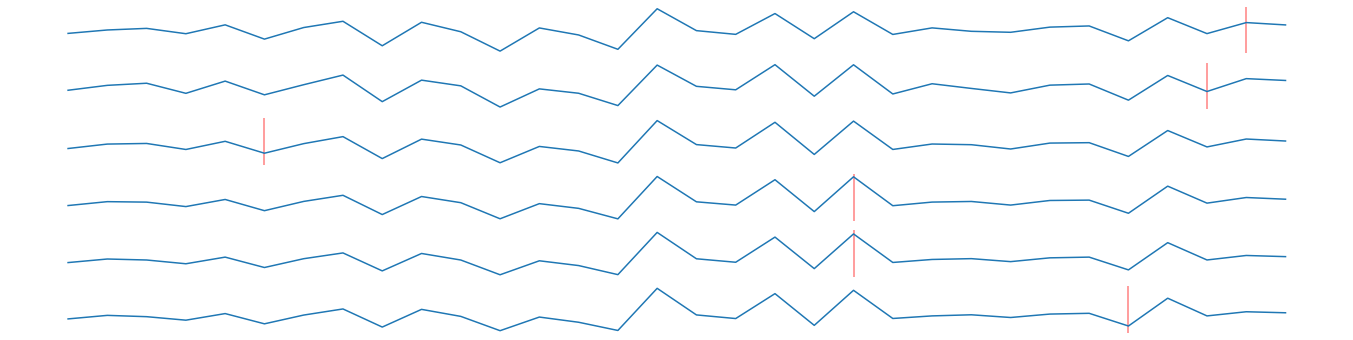

Training lstm ..
Rewards: [5.515, 5.791, 5.54, 5.53, 5.515]
lstm loss (epochs average): 4.309245701250575e-05
NAS epoch 57
Epoch average accuracy (5 sequences): 0.624


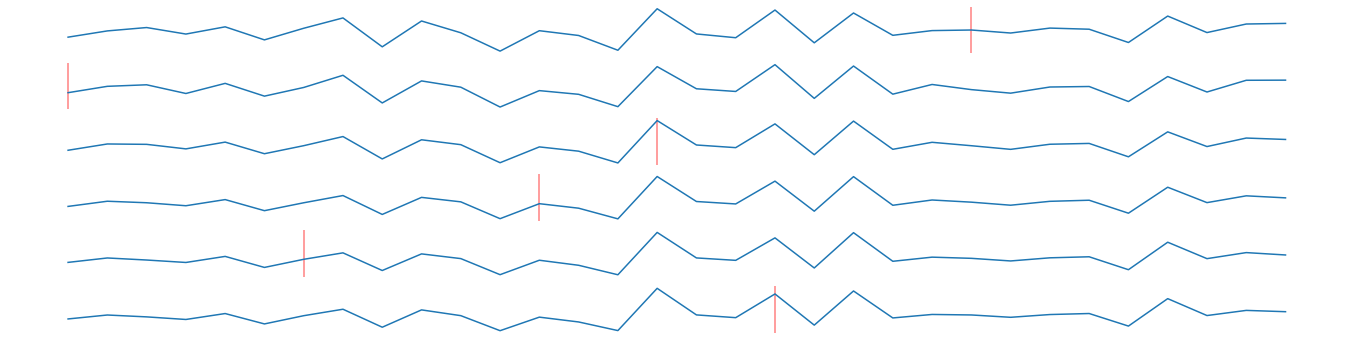

Training lstm ..
Rewards: [5.516, 5.754, 5.516, 5.817, 5.516]
lstm loss (epochs average): -5.69534296346319e-05
NAS epoch 58
Epoch average accuracy (5 sequences): 0.625


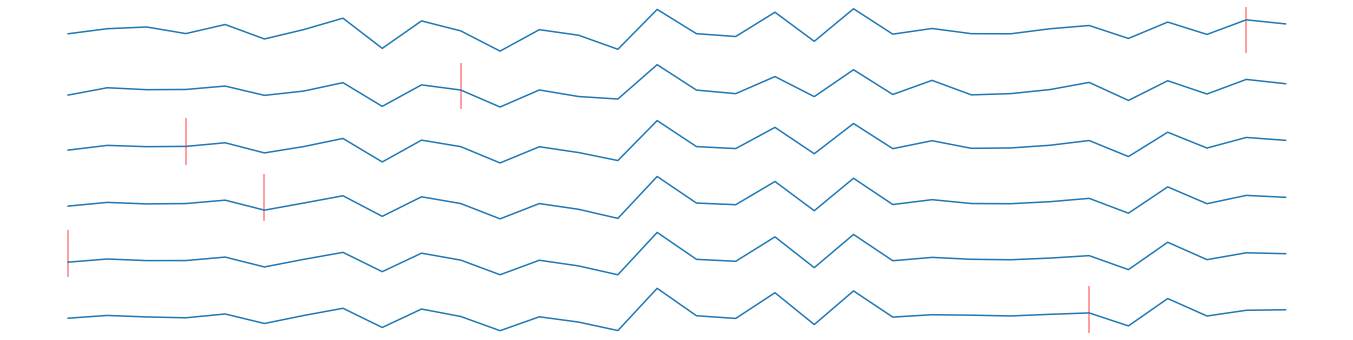

Training lstm ..
Rewards: [5.562, 5.518, 5.822, 5.707, 5.515]
lstm loss (epochs average): -0.0004487184884283124
NAS epoch 59
Epoch average accuracy (5 sequences): 0.654


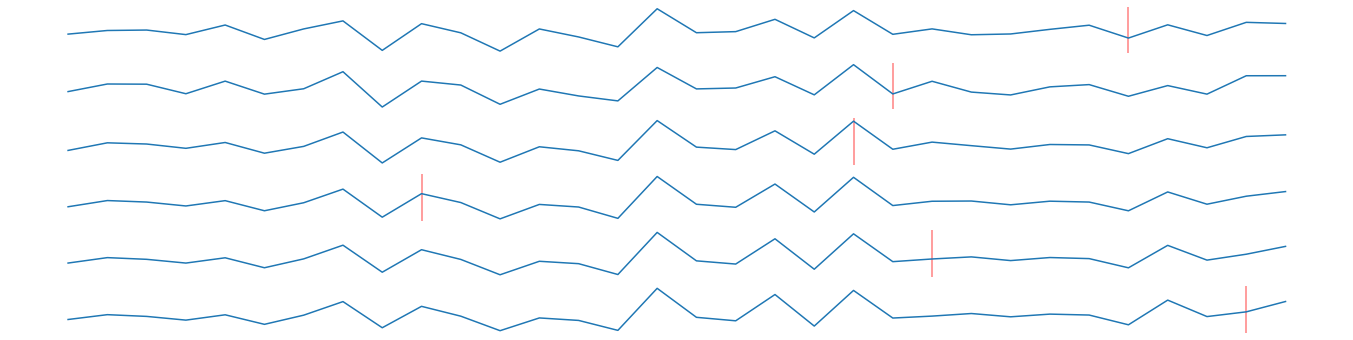

Training lstm ..
Rewards: [5.516, 5.804, 5.567, 5.555, 5.829]
lstm loss (epochs average): -0.0005777709629910532
NAS epoch 60
Epoch average accuracy (5 sequences): 0.672


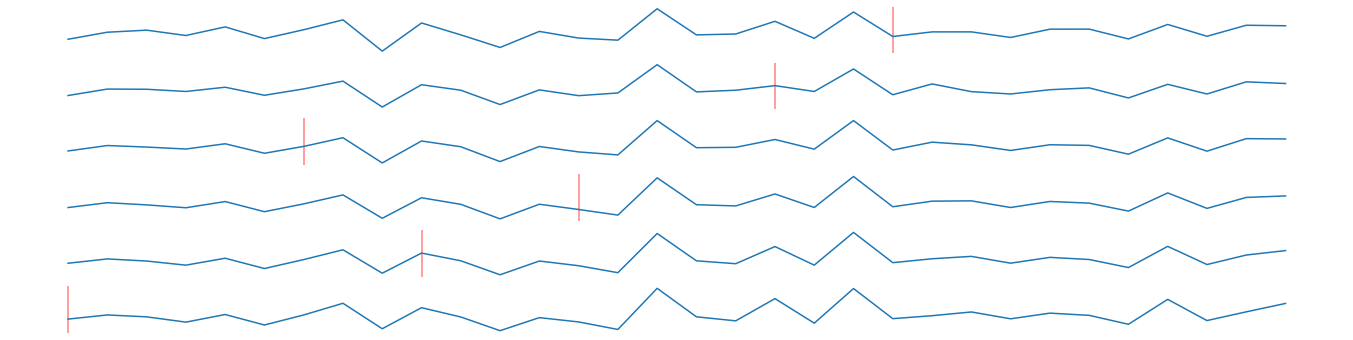

Training lstm ..
Rewards: [5.517, 5.532, 5.817, 5.818, 5.678]
lstm loss (epochs average): -0.001453689015221471
NAS epoch 61
Epoch average accuracy (5 sequences): 0.621


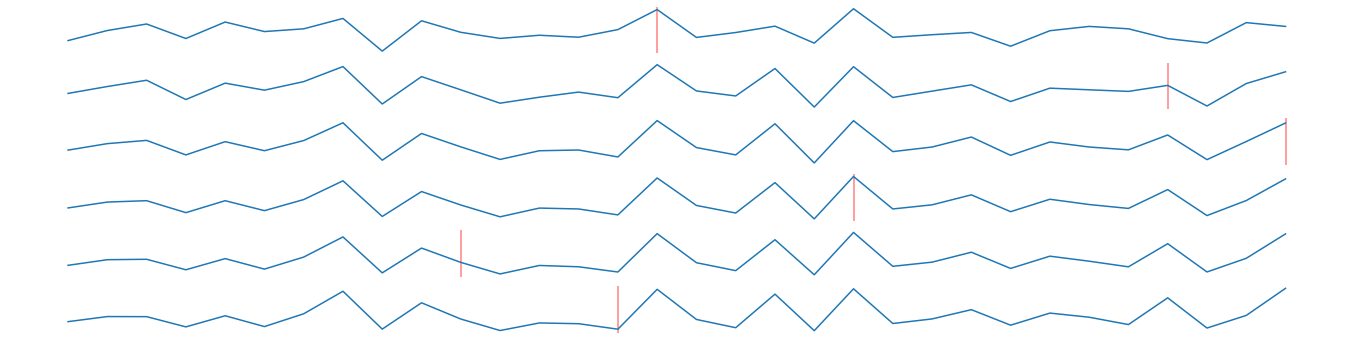

Training lstm ..
Rewards: [5.516, 5.78, 5.516, 5.778, 5.515]
lstm loss (epochs average): -0.0016546228221159254
NAS epoch 62
Epoch average accuracy (5 sequences): 0.629


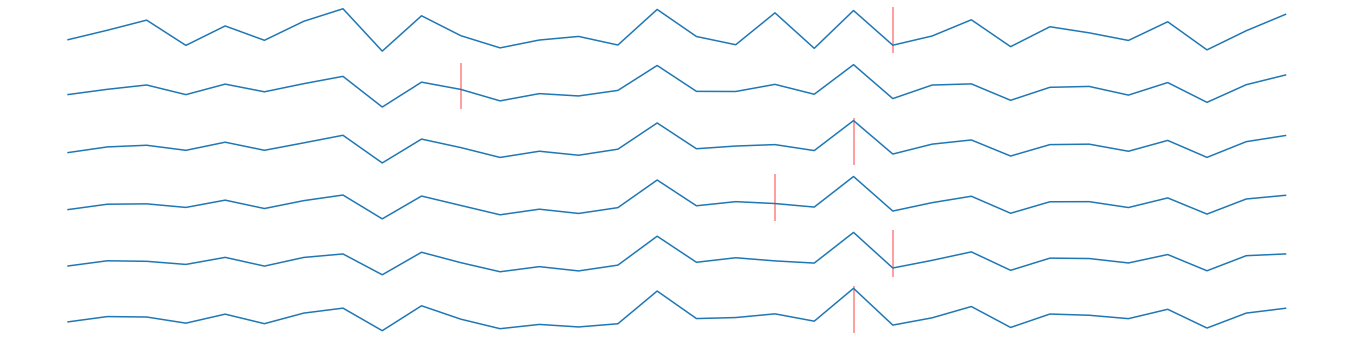

Training lstm ..
Rewards: [5.529, 5.518, 5.526, 5.776, 5.797]
lstm loss (epochs average): 0.0018920851252914872
NAS epoch 63
Epoch average accuracy (5 sequences): 0.745


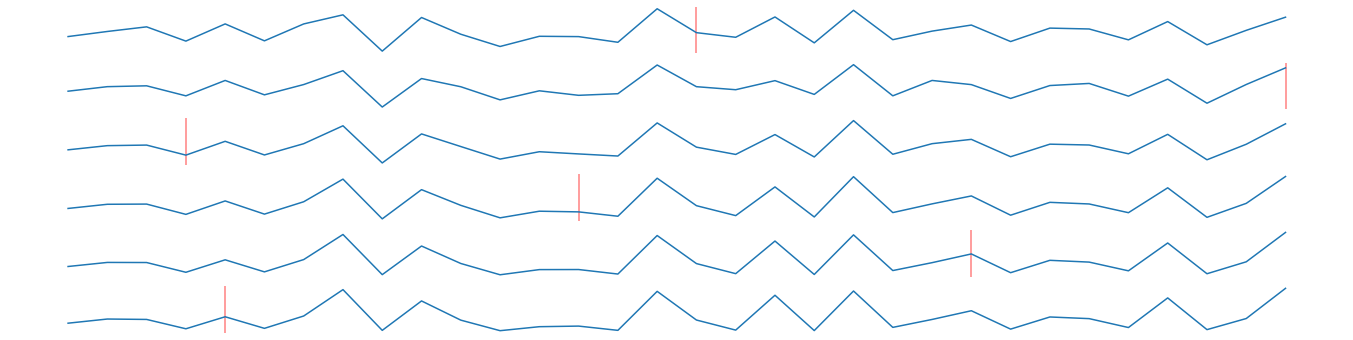

Training lstm ..
Rewards: [5.813, 5.57, 5.764, 5.797, 5.783]
lstm loss (epochs average): 0.0005404579683272459
NAS epoch 64
Epoch average accuracy (5 sequences): 0.622


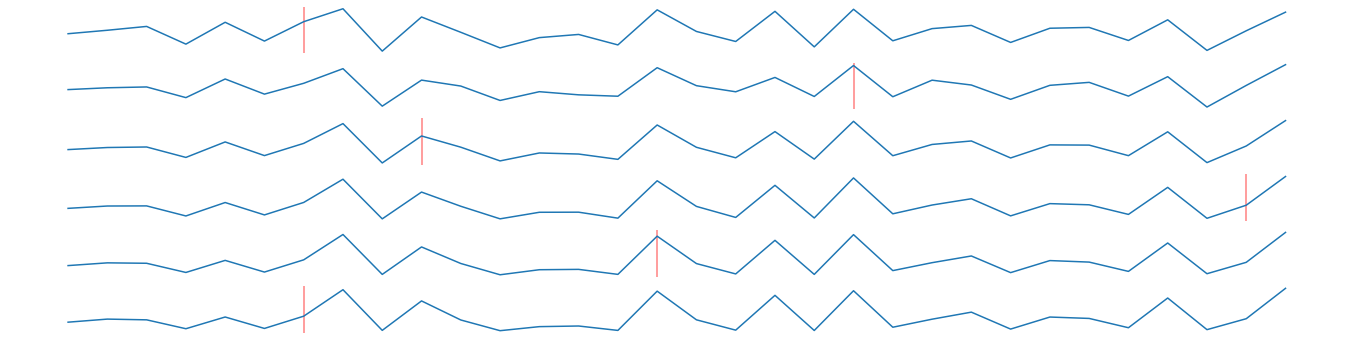

Training lstm ..
Rewards: [5.516, 5.515, 5.523, 5.803, 5.753]
lstm loss (epochs average): 0.002240409460682713
NAS epoch 65
Epoch average accuracy (5 sequences): 0.677


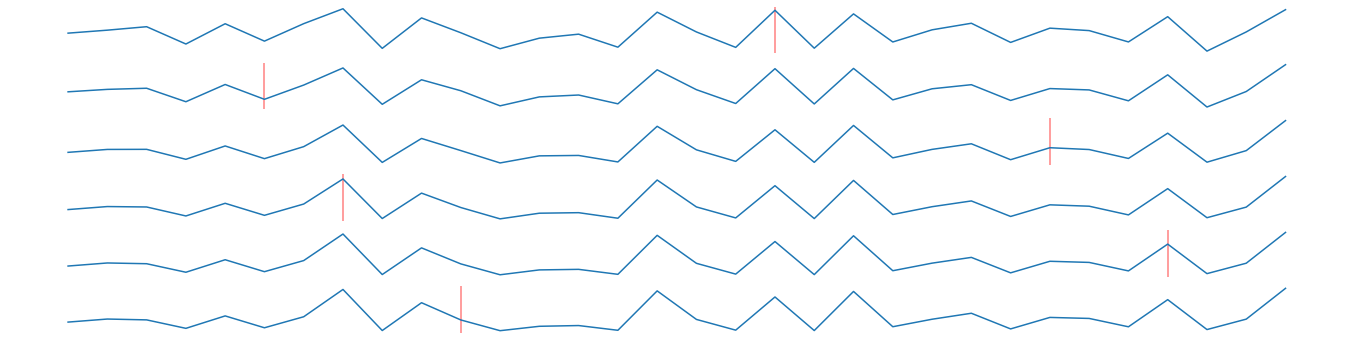

Training lstm ..
Rewards: [5.766, 5.796, 5.793, 5.515, 5.515]
lstm loss (epochs average): 0.00028768247688049087
NAS epoch 66
Epoch average accuracy (5 sequences): 0.673


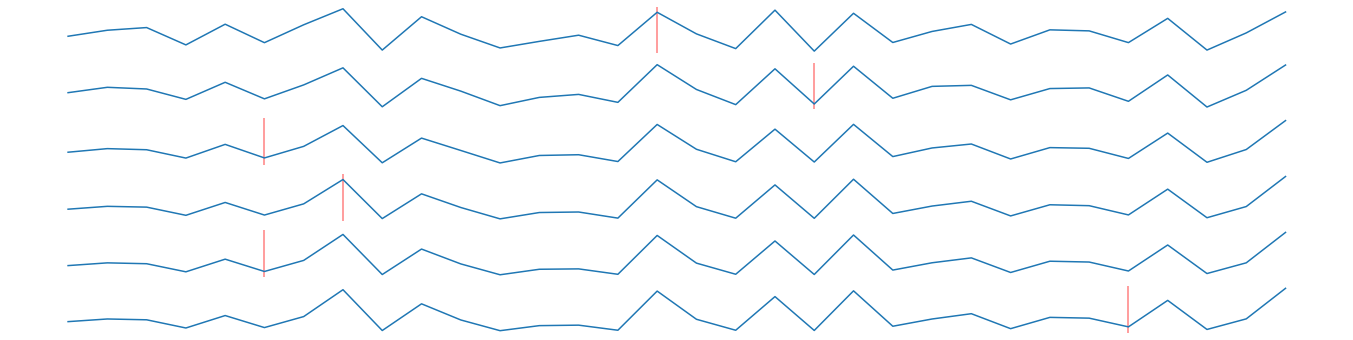

Training lstm ..
Rewards: [5.573, 5.781, 5.557, 5.767, 5.687]
lstm loss (epochs average): -1.4799182736169314e-05
NAS epoch 67
Epoch average accuracy (5 sequences): 0.681


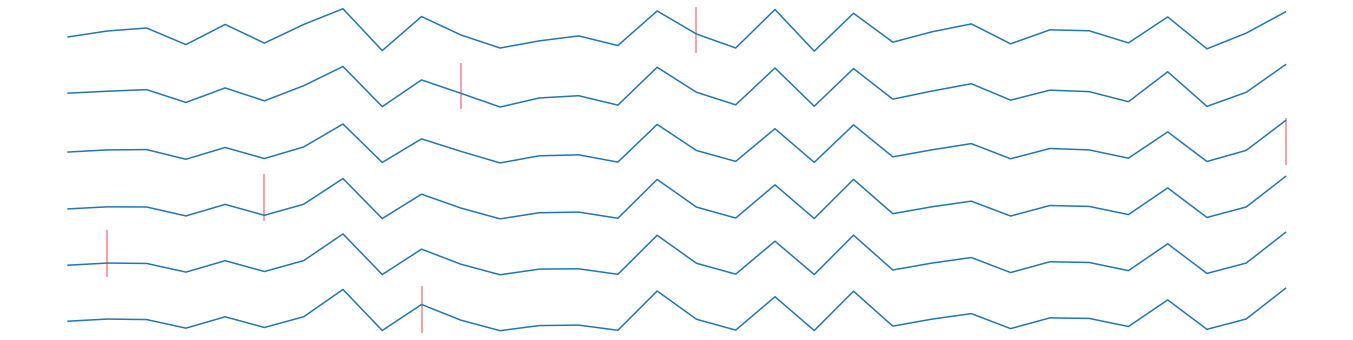

Training lstm ..
Rewards: [5.674, 5.809, 5.661, 5.746, 5.517]
lstm loss (epochs average): -0.0006659222372320528
NAS epoch 68
Epoch average accuracy (5 sequences): 0.58


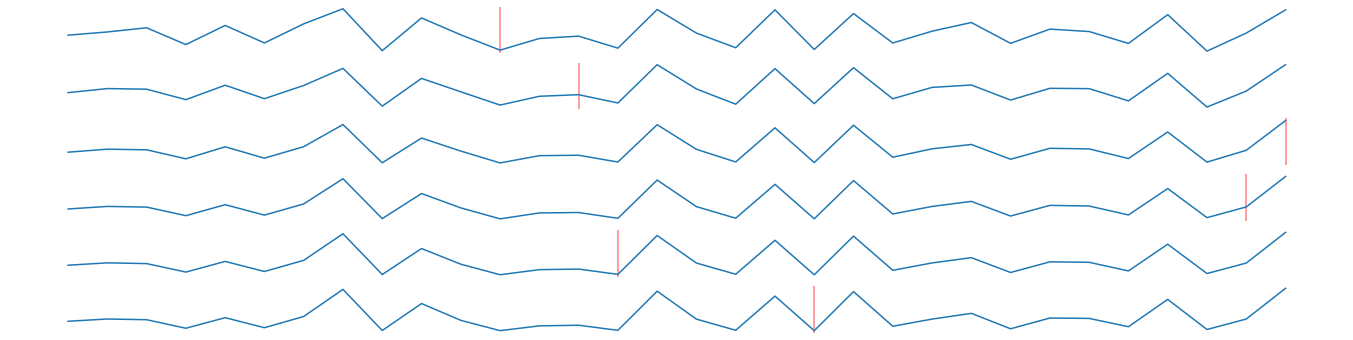

Training lstm ..
Rewards: [5.798, 5.517, 5.515, 5.531, 5.538]
lstm loss (epochs average): 0.0007093031076692569
NAS epoch 69
Epoch average accuracy (5 sequences): 0.623


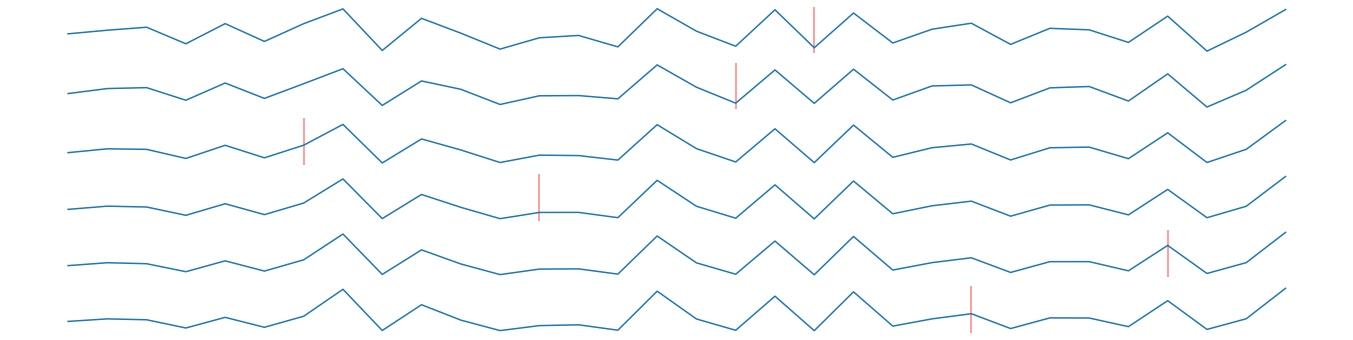

Training lstm ..
Rewards: [5.516, 5.516, 5.795, 5.533, 5.755]
lstm loss (epochs average): 9.20687489269767e-06
NAS epoch 70
Epoch average accuracy (5 sequences): 0.723


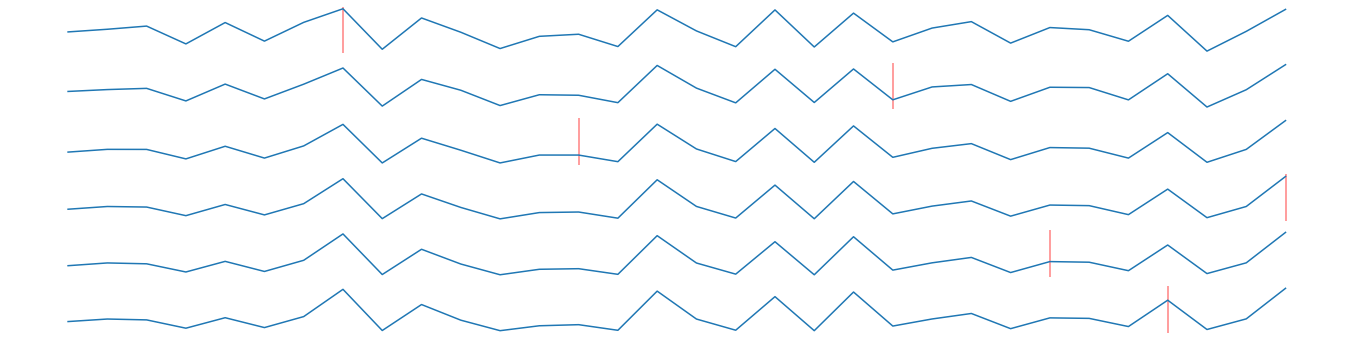

Training lstm ..
Rewards: [5.783, 5.775, 5.774, 5.516, 5.768]
lstm loss (epochs average): 4.648952017305419e-05
NAS epoch 71
Epoch average accuracy (5 sequences): 0.621


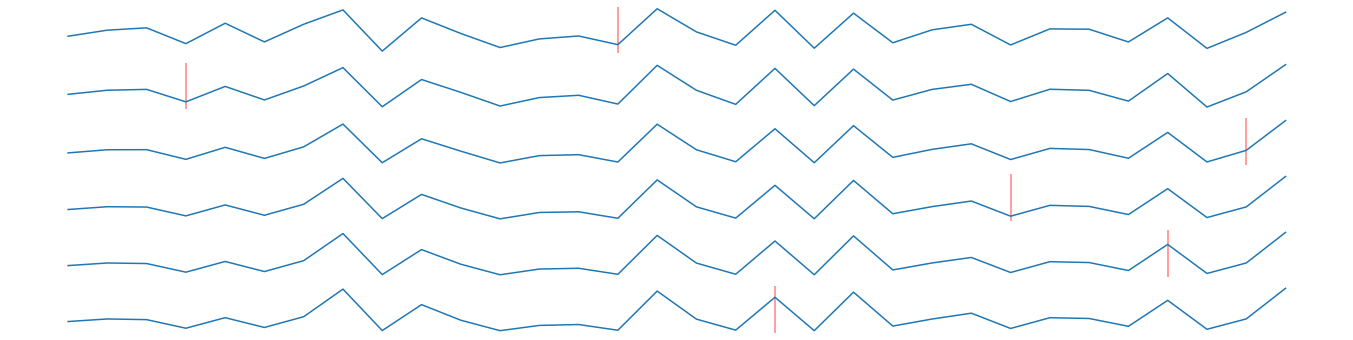

Training lstm ..
Rewards: [5.801, 5.517, 5.517, 5.757, 5.515]
lstm loss (epochs average): 0.00045603713169839466
NAS epoch 72
Epoch average accuracy (5 sequences): 0.661


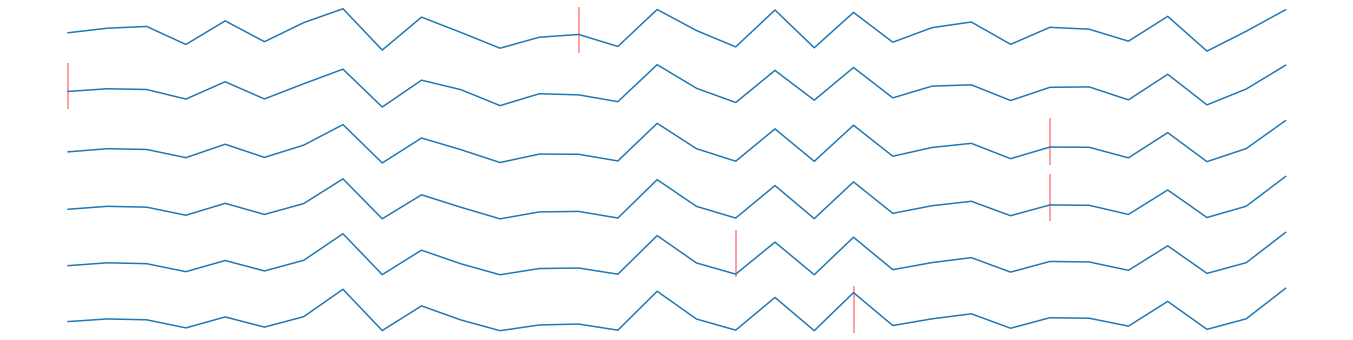

Training lstm ..
Rewards: [5.678, 5.799, 5.517, 5.797, 5.515]
lstm loss (epochs average): -0.00041349933474066347
NAS epoch 73
Epoch average accuracy (5 sequences): 0.638


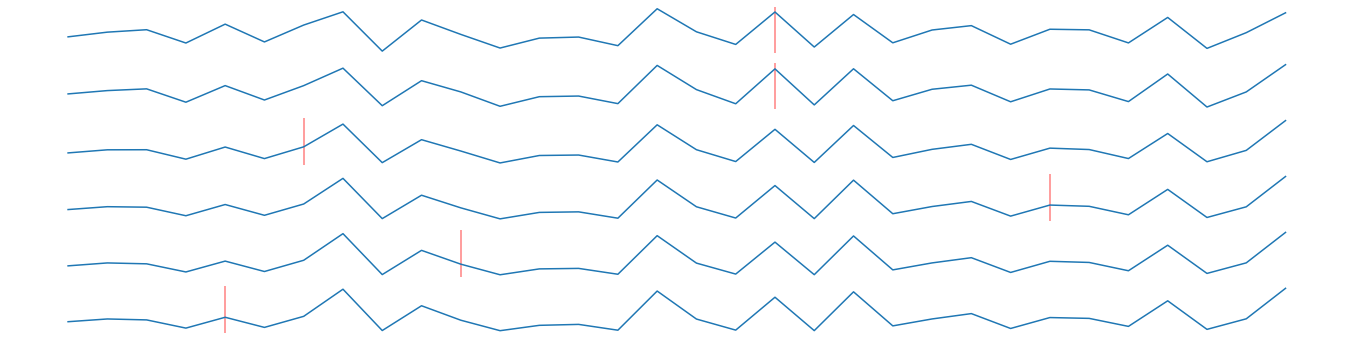

Training lstm ..
Rewards: [5.668, 5.699, 5.515, 5.791, 5.519]
lstm loss (epochs average): -0.00031859347598128807
NAS epoch 74
Epoch average accuracy (5 sequences): 0.656


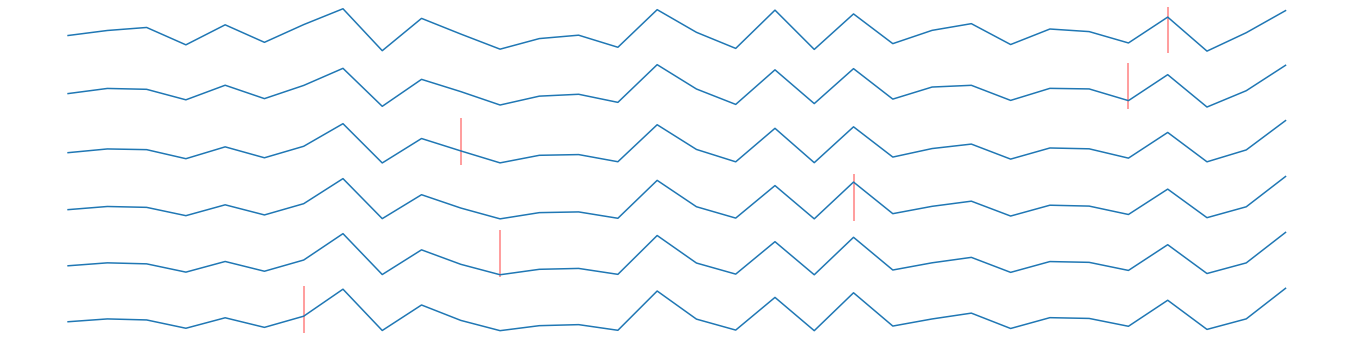

Training lstm ..
Rewards: [5.718, 5.775, 5.682, 5.588, 5.516]
lstm loss (epochs average): -0.0013926728170190472
NAS epoch 75
Epoch average accuracy (5 sequences): 0.661


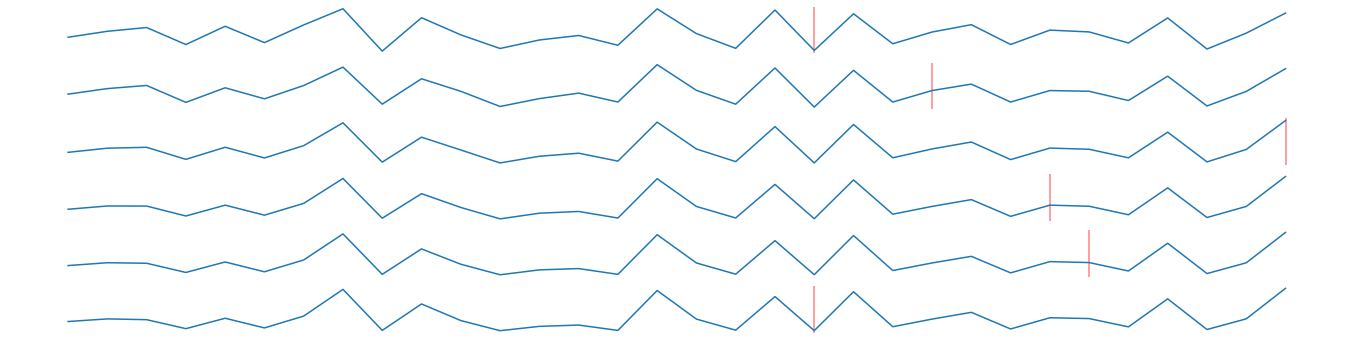

Training lstm ..
Rewards: [5.535, 5.84, 5.635, 5.777, 5.516]
lstm loss (epochs average): 0.0017059614465324557
NAS epoch 76
Epoch average accuracy (5 sequences): 0.63


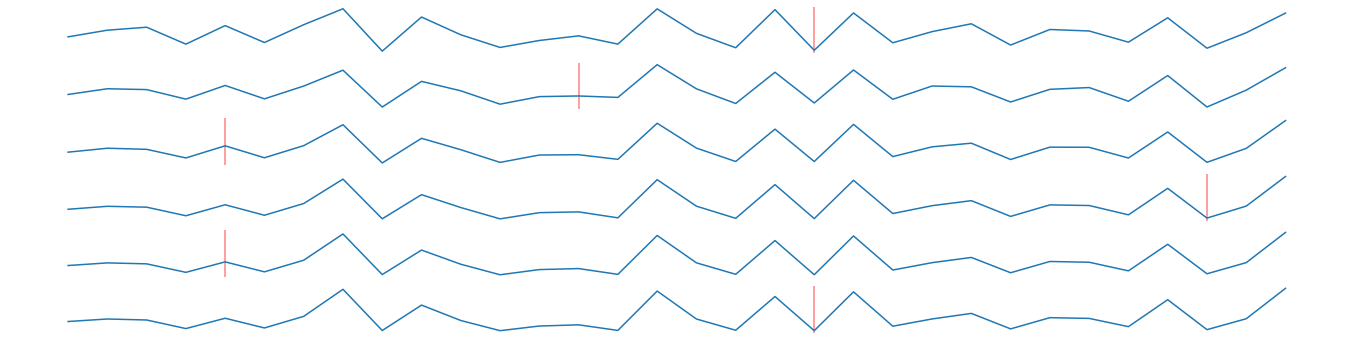

Training lstm ..
Rewards: [5.789, 5.517, 5.517, 5.796, 5.533]
lstm loss (epochs average): 0.0007362054202530999
NAS epoch 77
Epoch average accuracy (5 sequences): 0.679


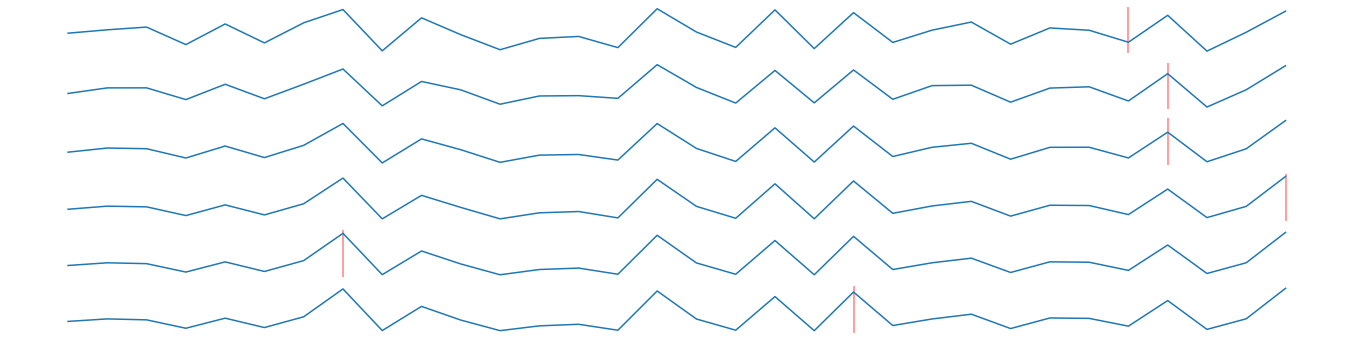

Training lstm ..
Rewards: [5.798, 5.519, 5.593, 5.79, 5.696]
lstm loss (epochs average): -5.2099614549661055e-05
NAS epoch 78
Epoch average accuracy (5 sequences): 0.655


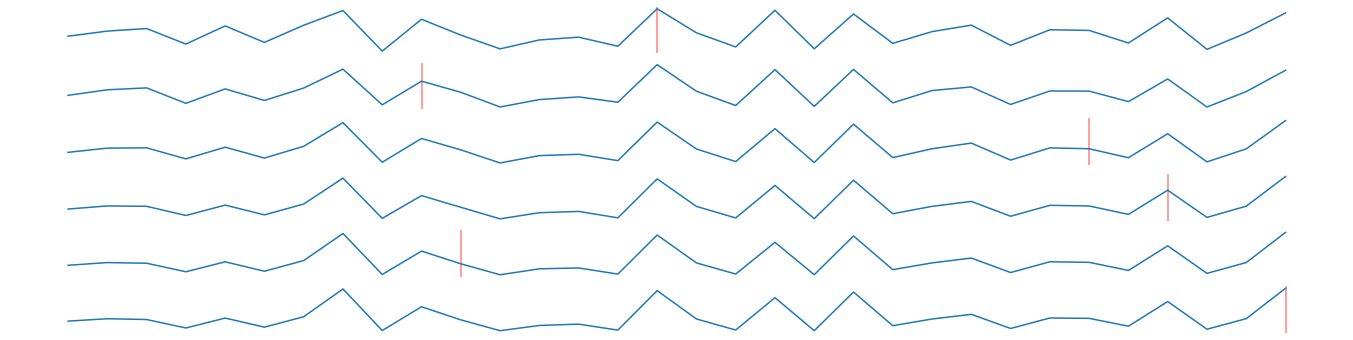

Training lstm ..
Rewards: [5.517, 5.515, 5.797, 5.645, 5.801]
lstm loss (epochs average): 0.00022137702561941808
NAS epoch 79
Epoch average accuracy (5 sequences): 0.573


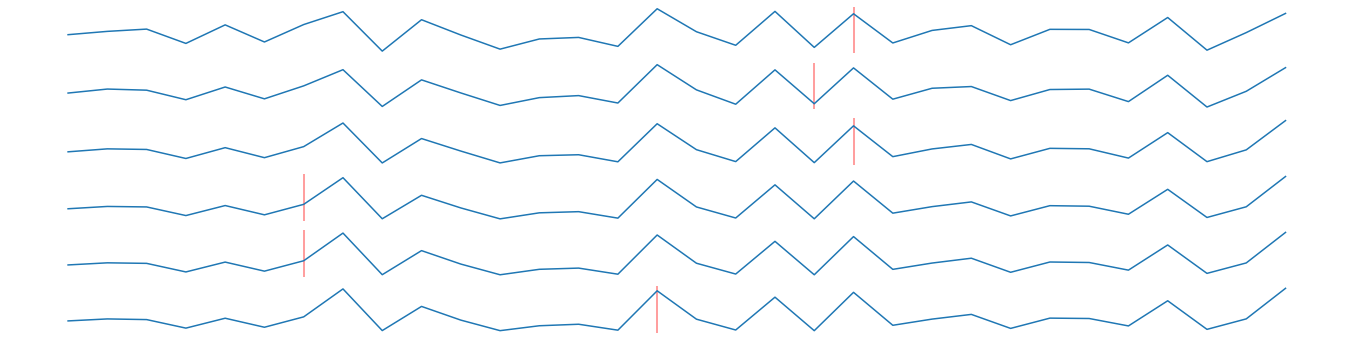

Training lstm ..
Rewards: [5.515, 5.515, 5.515, 5.804, 5.517]
lstm loss (epochs average): 0.00022032774273839095
NAS epoch 80
Epoch average accuracy (5 sequences): 0.517


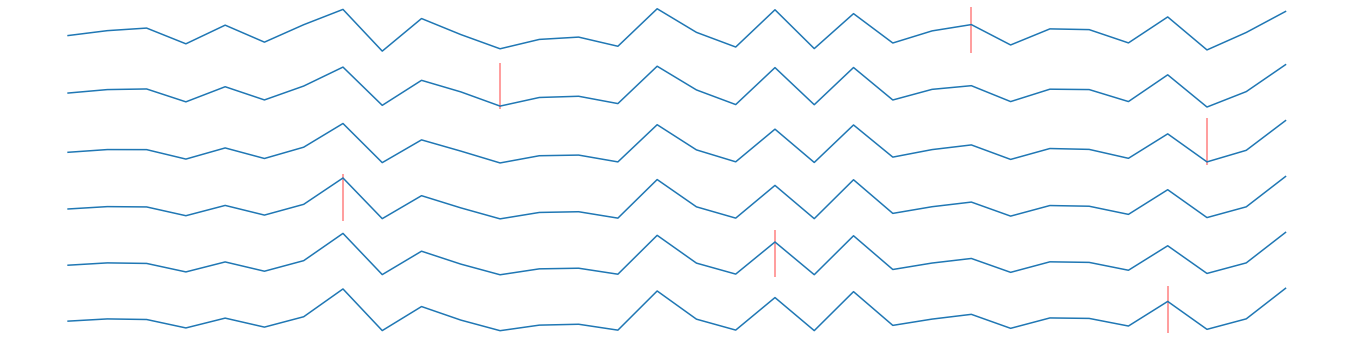

Training lstm ..
Rewards: [5.515, 5.523, 5.516, 5.516, 5.516]
lstm loss (epochs average): -7.528697460656986e-05
NAS epoch 81
Epoch average accuracy (5 sequences): 0.619


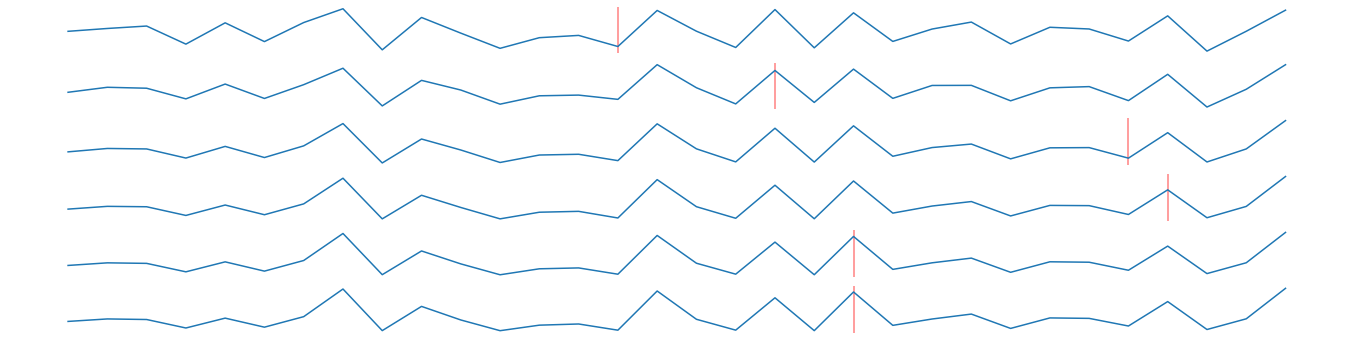

Training lstm ..
Rewards: [5.518, 5.516, 5.768, 5.516, 5.779]
lstm loss (epochs average): -0.0006736115401508869
NAS epoch 82
Epoch average accuracy (5 sequences): 0.583


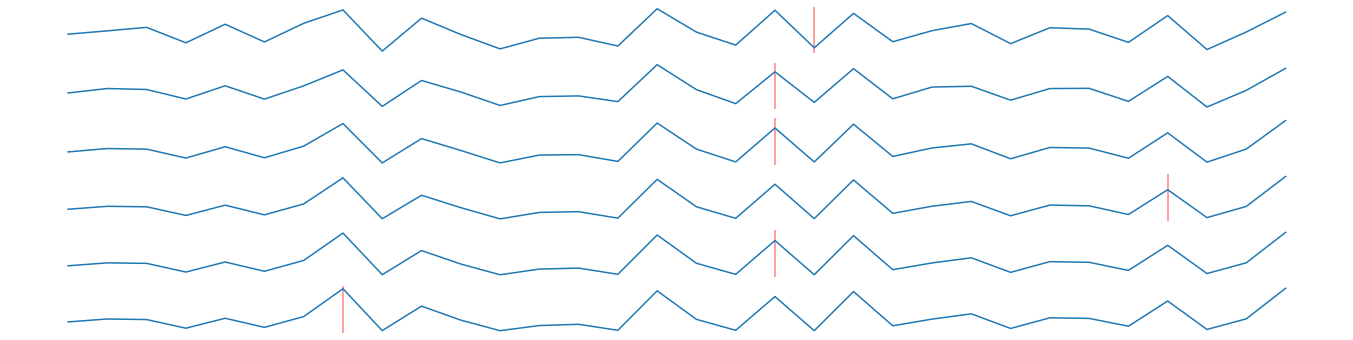

Training lstm ..
Rewards: [5.789, 5.563, 5.532, 5.517, 5.516]
lstm loss (epochs average): 0.00019003177339982358
NAS epoch 83
Epoch average accuracy (5 sequences): 0.711


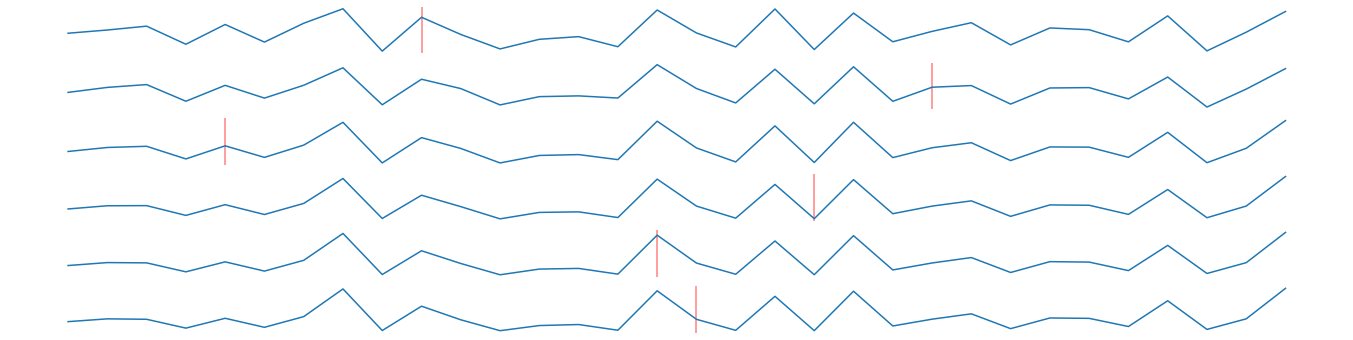

Training lstm ..
Rewards: [5.796, 5.815, 5.784, 5.515, 5.643]
lstm loss (epochs average): -0.0009751397301442921
NAS epoch 84
Epoch average accuracy (5 sequences): 0.73


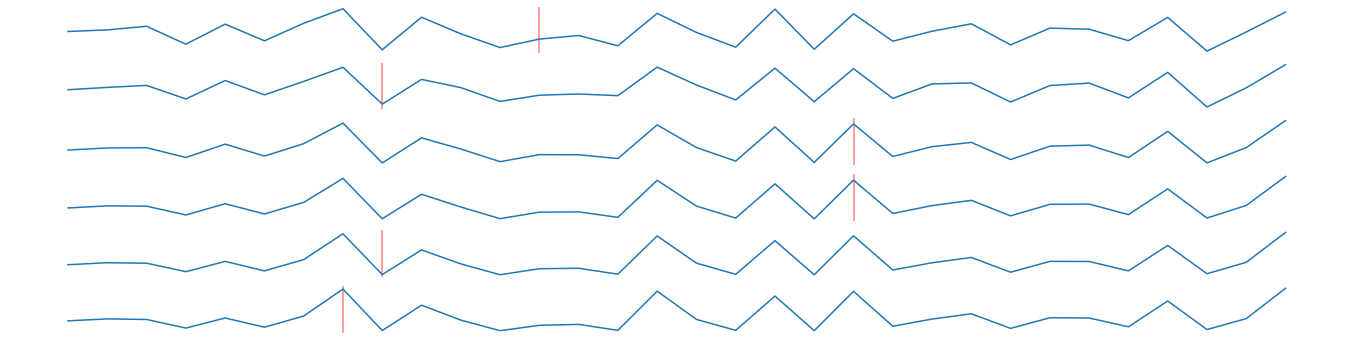

Training lstm ..
Rewards: [5.761, 5.805, 5.794, 5.516, 5.774]
lstm loss (epochs average): 0.0011090899106420693
NAS epoch 85
Epoch average accuracy (5 sequences): 0.729


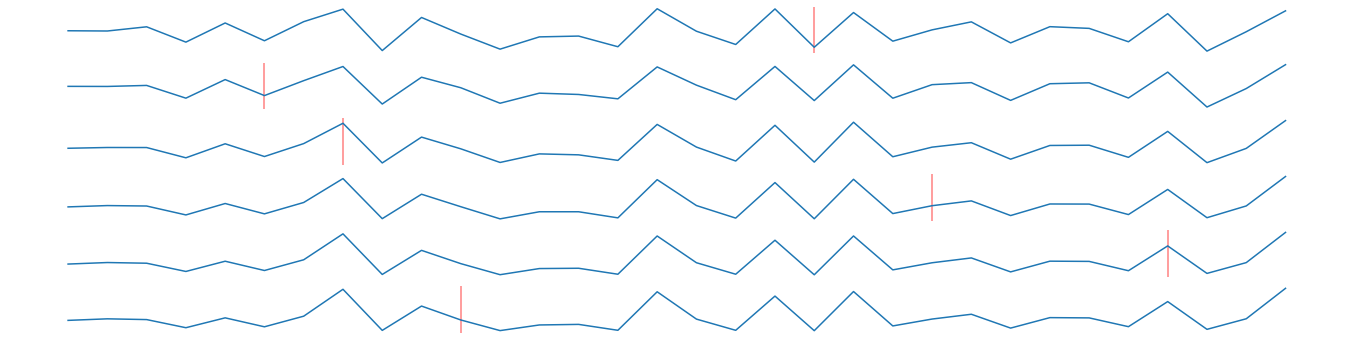

Training lstm ..
Rewards: [5.516, 5.786, 5.8, 5.788, 5.753]
lstm loss (epochs average): 0.0003773698481381871
NAS epoch 86
Epoch average accuracy (5 sequences): 0.554


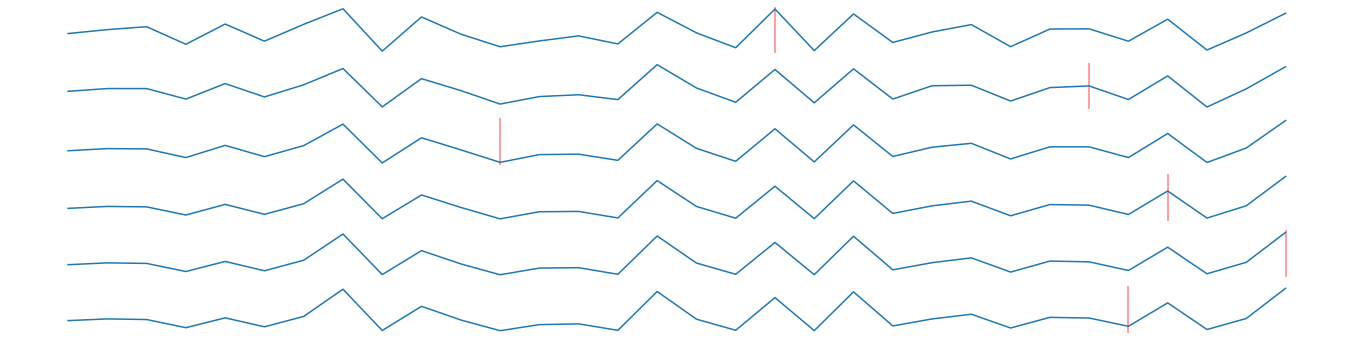

Training lstm ..
Rewards: [5.516, 5.515, 5.654, 5.515, 5.572]
lstm loss (epochs average): 0.00026704460310611466
NAS epoch 87
Epoch average accuracy (5 sequences): 0.579


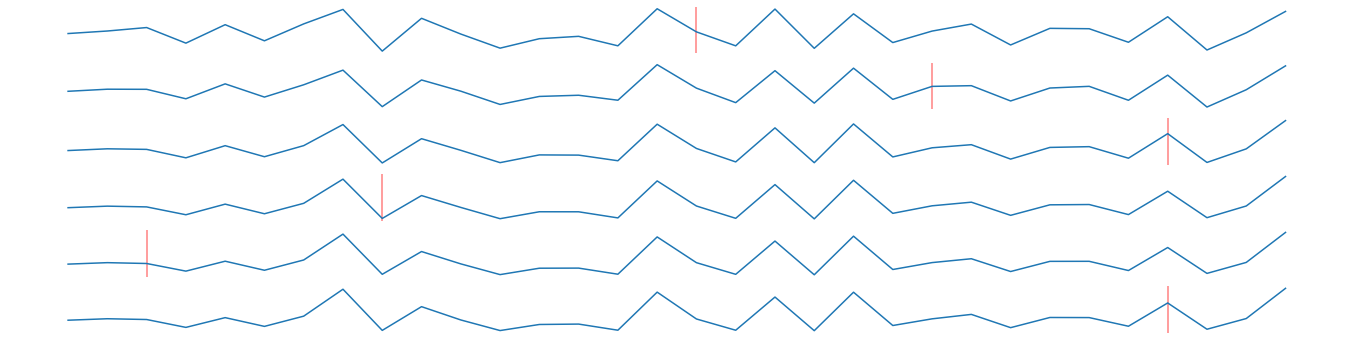

Training lstm ..
Rewards: [5.815, 5.535, 5.515, 5.515, 5.516]
lstm loss (epochs average): 0.0005617371331823051
NAS epoch 88
Epoch average accuracy (5 sequences): 0.589


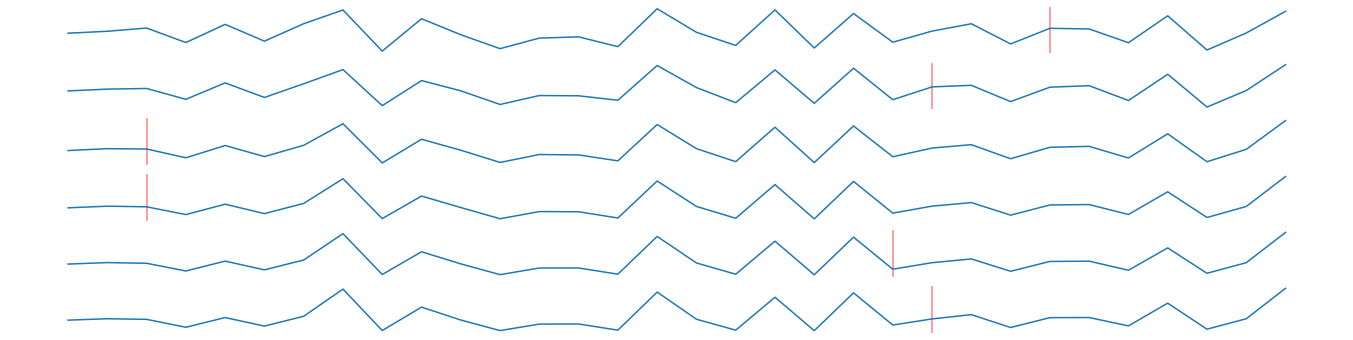

Training lstm ..
Rewards: [5.52, 5.599, 5.794, 5.516, 5.517]
lstm loss (epochs average): 3.111807973255054e-05
NAS epoch 89
Epoch average accuracy (5 sequences): 0.715


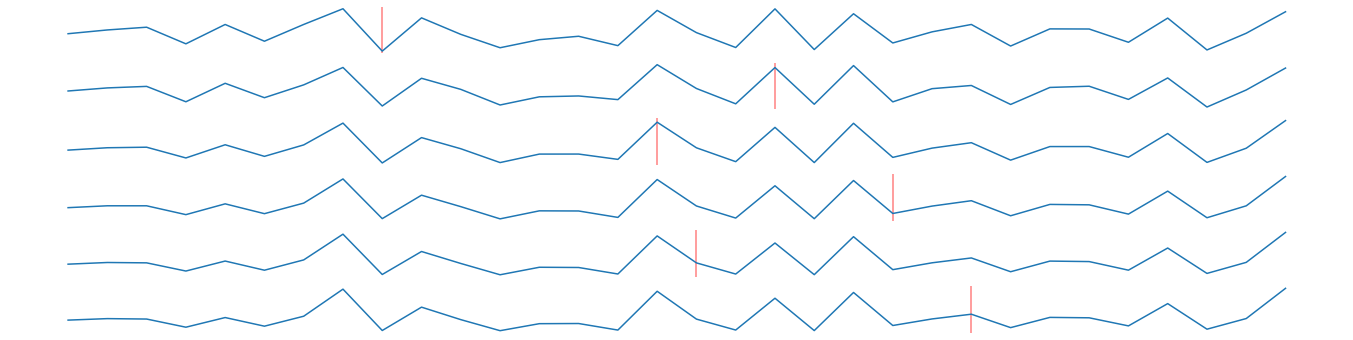

Training lstm ..
Rewards: [5.642, 5.764, 5.801, 5.516, 5.853]
lstm loss (epochs average): 0.00017405759228950046
NAS epoch 90
Epoch average accuracy (5 sequences): 0.736


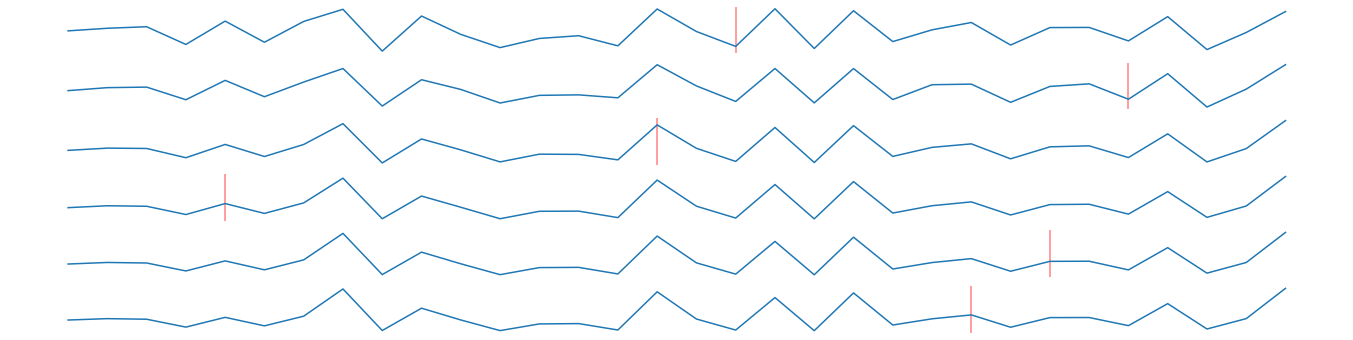

Training lstm ..
Rewards: [5.804, 5.801, 5.515, 5.769, 5.793]
lstm loss (epochs average): -0.0004980904486160398
NAS epoch 91
Epoch average accuracy (5 sequences): 0.742


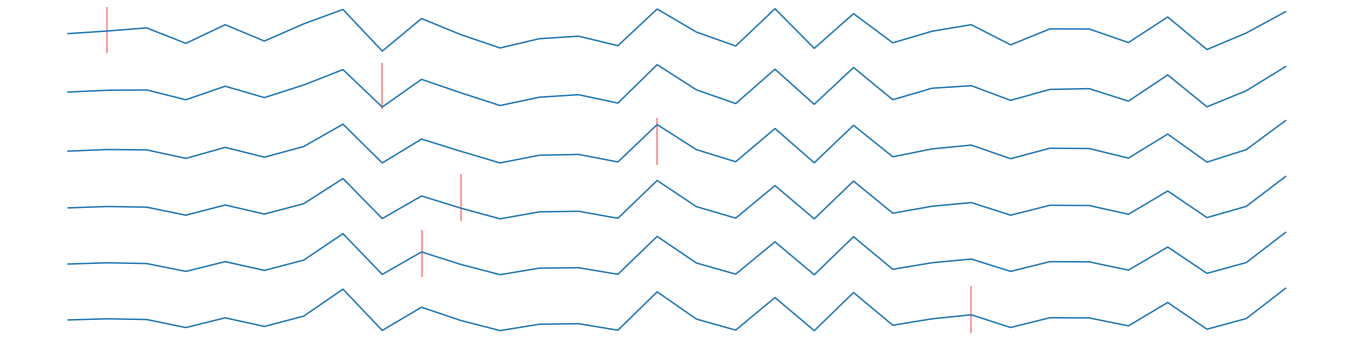

Training lstm ..
Rewards: [5.515, 5.824, 5.796, 5.818, 5.755]
lstm loss (epochs average): -0.00020126867860881248
NAS epoch 92
Epoch average accuracy (5 sequences): 0.608


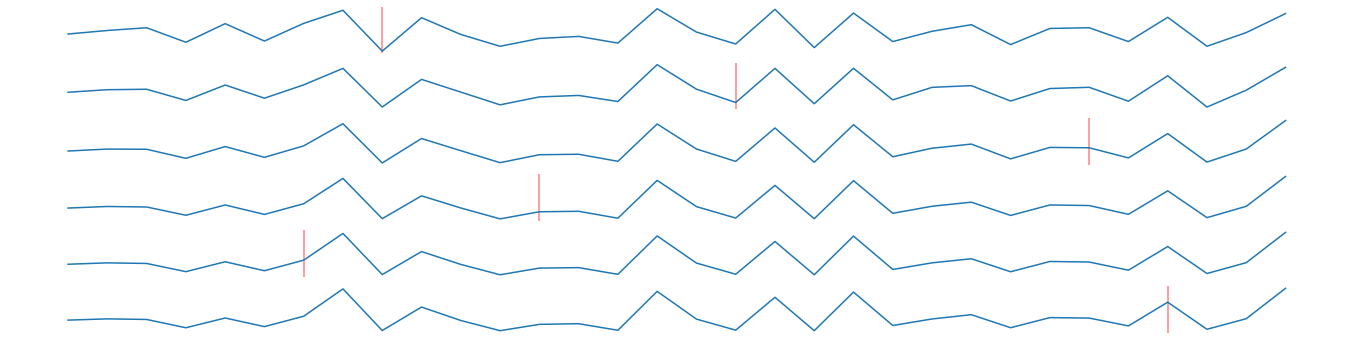

Training lstm ..
Rewards: [5.708, 5.516, 5.515, 5.516, 5.787]
lstm loss (epochs average): -0.00027283632198304986
NAS epoch 93
Epoch average accuracy (5 sequences): 0.68


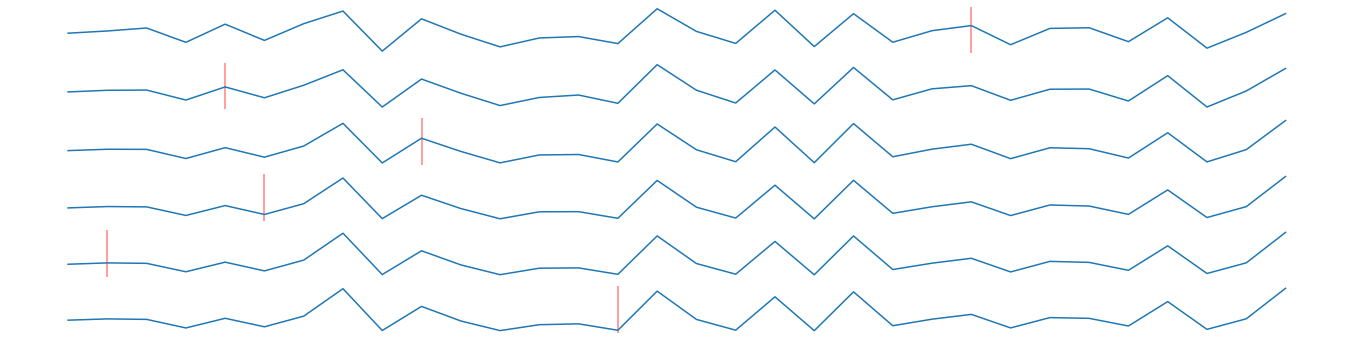

Training lstm ..
Rewards: [5.795, 5.782, 5.516, 5.791, 5.515]
lstm loss (epochs average): -0.0005373580629566277
NAS epoch 94
Epoch average accuracy (5 sequences): 0.669


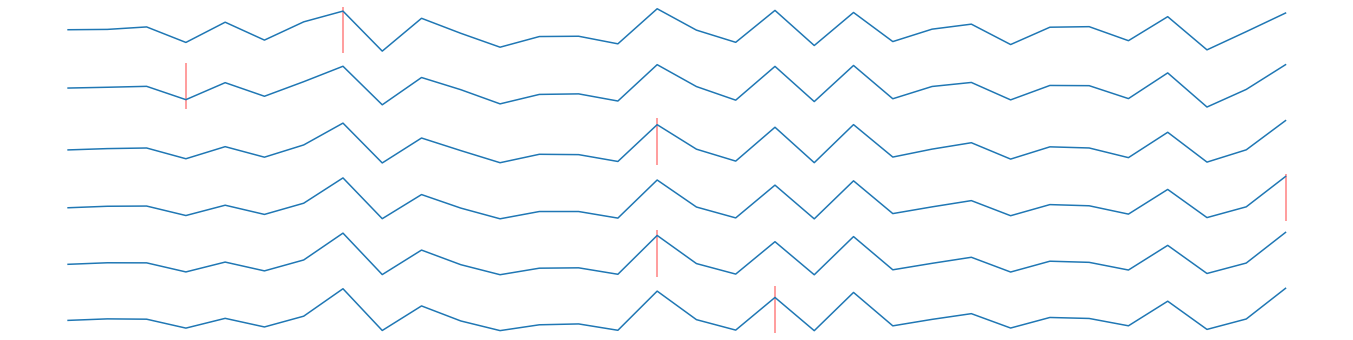

Training lstm ..
Rewards: [5.771, 5.521, 5.77, 5.762, 5.519]
lstm loss (epochs average): 0.0005401914448839307
NAS epoch 95
Epoch average accuracy (5 sequences): 0.635


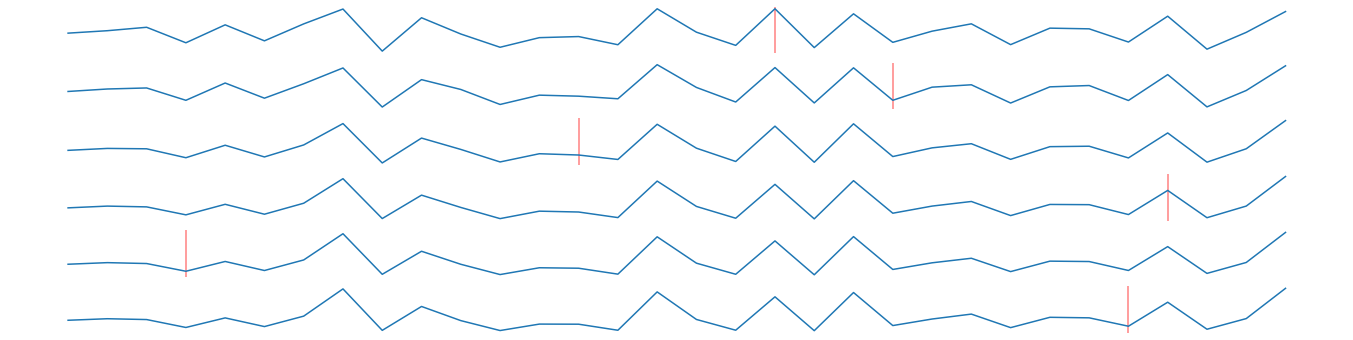

Training lstm ..
Rewards: [5.516, 5.517, 5.809, 5.815, 5.516]
lstm loss (epochs average): -0.0003996432565145369
NAS epoch 96
Epoch average accuracy (5 sequences): 0.626


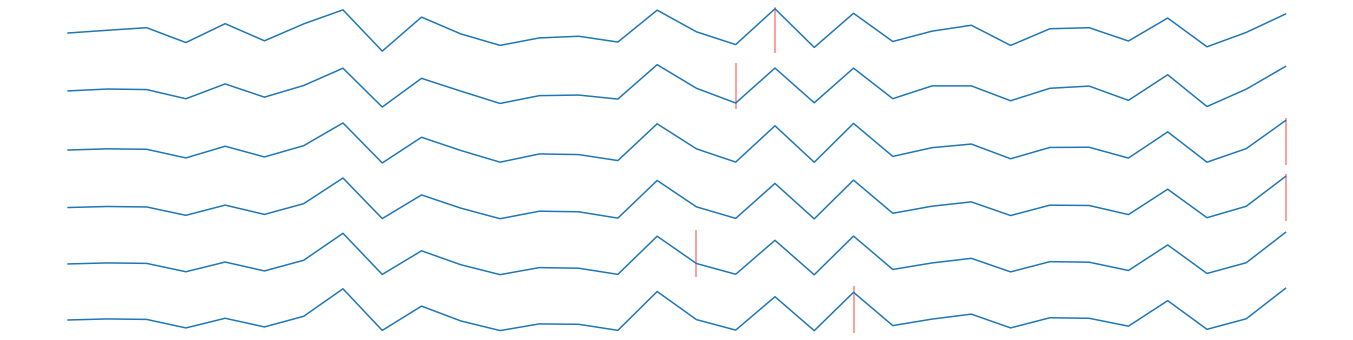

Training lstm ..
Rewards: [5.767, 5.787, 5.544, 5.516, 5.516]
lstm loss (epochs average): 0.0008860839952831157
NAS epoch 97
Epoch average accuracy (5 sequences): 0.614


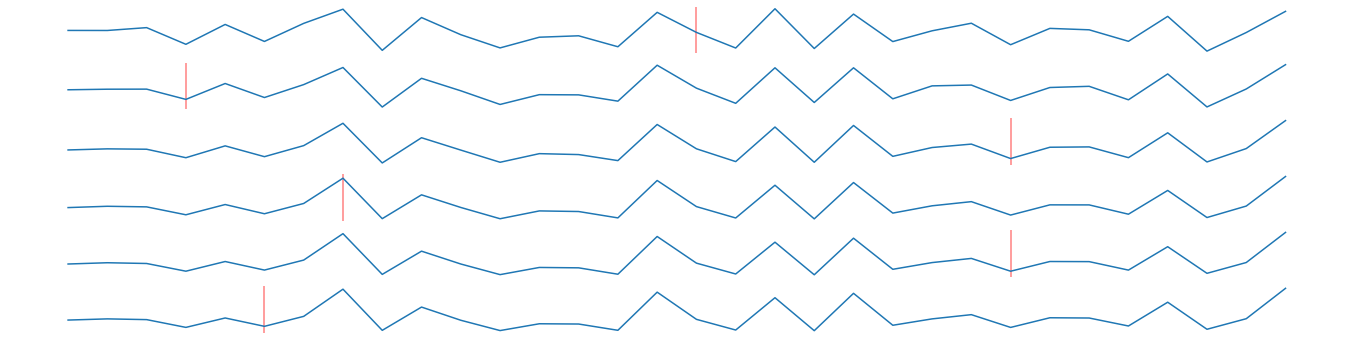

Training lstm ..
Rewards: [5.796, 5.516, 5.57, 5.58, 5.606]
lstm loss (epochs average): 0.00019862182909946569
NAS epoch 98
Epoch average accuracy (5 sequences): 0.626


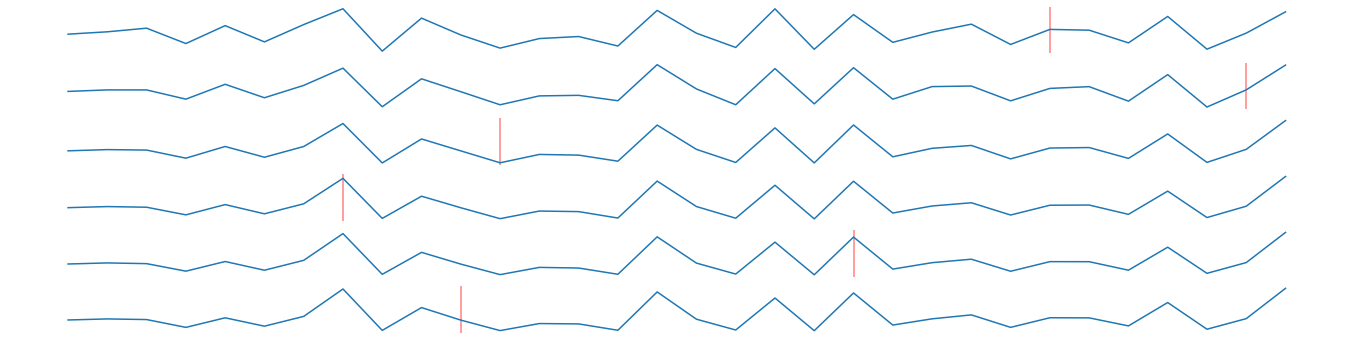

Training lstm ..
Rewards: [5.781, 5.803, 5.517, 5.515, 5.515]
lstm loss (epochs average): -7.710045357711692e-05
NAS epoch 99
Epoch average accuracy (5 sequences): 0.697


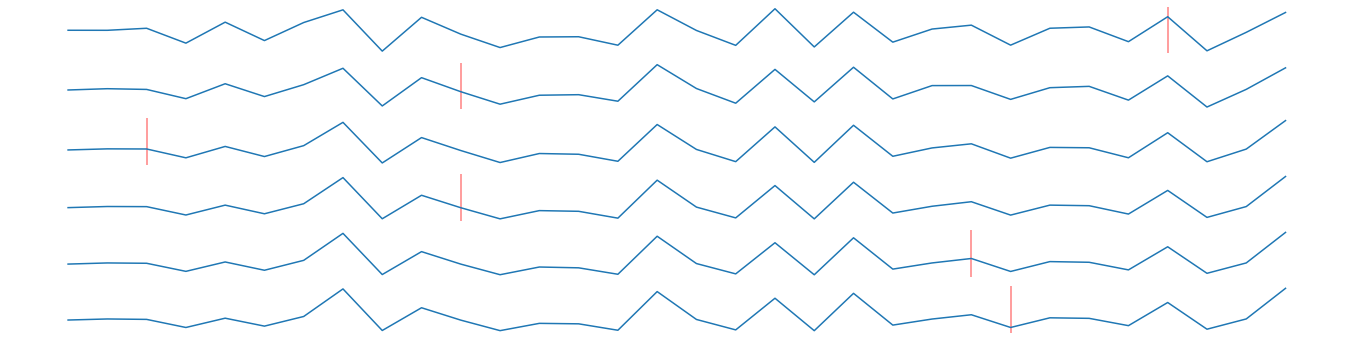

Training lstm ..
Rewards: [5.817, 5.785, 5.74, 5.525, 5.62]
lstm loss (epochs average): 0.00010900292261339928
NAS epoch 100
Epoch average accuracy (5 sequences): 0.629


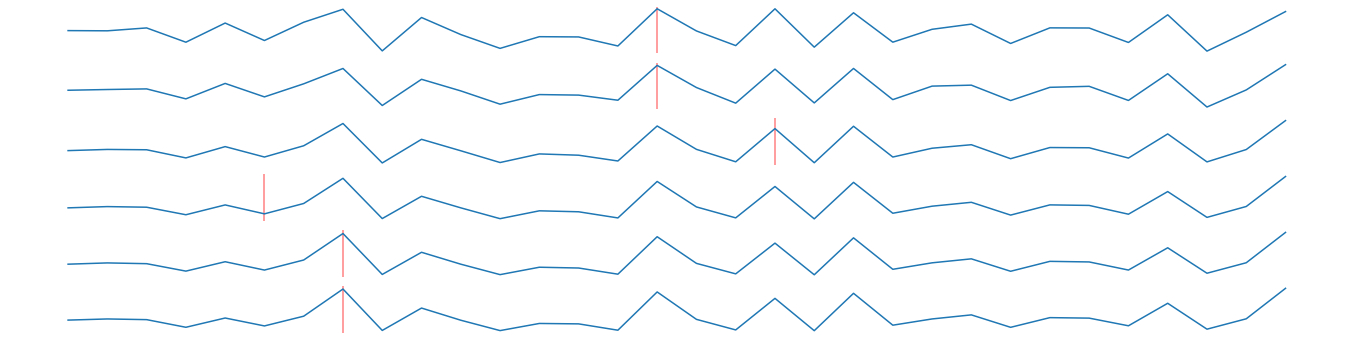

Training lstm ..
Rewards: [5.809, 5.786, 5.517, 5.516, 5.517]
lstm loss (epochs average): -8.38274395391636e-05
Done.


In [15]:
history_data_x = []
history_data_acc = []
history_lstm_loss = []
history_avg_acc = []
history_rewards = []
valid_layers = get_dictionary()

for nas_epoch in range(no_of_nas_epochs):
    sequences = []
    data_x = None
    accuracies = []
    data_acc = None
    print("NAS epoch", nas_epoch+1)
    sample_seq = 0
    while sample_seq < no_of_samples_per_epoch:
        sequence = np.zeros((1, no_of_layer_params, max_no_of_layers-1), dtype="int32")
        sequence_tokens = []
        layer = 0
        while layer < max_no_of_layers-1:
            distribution = model.predict(sequence)
            selected_ = []
            for prob in distribution[0]:
                selected = np.random.choice(distribution_space, size=1, p=prob)[0]
                selected_.append(selected)  
            info_0 = map_dist_to_layer_param(distribution_space, "layers", int(selected_[0])) 
            layer_params = [info_0]
            if info_0 in [1,2]:
                for i, param_name in enumerate(["filters", "kernel_sizes", "strides", "paddings", "activations"]):
                    info_ = map_dist_to_layer_param(distribution_space, param_name, int(selected_[i+1])) 
                    layer_params.append(info_)
            if info_0 == 3:
                for i, param_name in enumerate(["nodes", None, None, None, "activations"]):
                    info_ = map_dist_to_layer_param(distribution_space, param_name, int(selected_[i+1])) 
                    layer_params.append(info_)
                    
            if tuple(layer_params) in valid_layers:
                sequence[0][:,layer] = layer_params
                sequence_tokens.append(valid_layers.index(tuple(layer_params))+1)
                layer += 1
                
        if not any(np.array_equal(sequence, x) for x in sequences):
            sequences.append(sequence)
            sequence_acc = performance_estimate(sequence_tokens + [int(distribution_space[-1])])
            accuracies.append(sequence_acc)
            sample_seq += 1

        data_acc = np.vstack(accuracies)
    
    avg_acc = round(np.average(accuracies),3)
    print(f"Epoch average accuracy ({no_of_samples_per_epoch} sequences):", avg_acc)
#     baseline = avg_acc + 0.05
    plot_distribution(distribution_space, distribution[0], selected_)
    print("Training lstm ..")
    rewards_ = (rew_coef * (data_acc - baseline)).tolist()
    print("Rewards:", [round(i[0], 4) for i in rewards_])
    data_x = np.array(sequences).reshape(len(sequences), no_of_layer_params, max_no_of_layers-1)
    data_y = np.zeros(tuple(list(data_x.shape) + [len(distribution_space)]))
    history = model.fit({'main_input': data_x},
                        {'main_output': data_y},
                        epochs=rnn_train_epochs,
                        batch_size=len(data_x),
                        verbose=0)
    lstm_loss_avg = np.average(list(history.history.values())[0])
    print("lstm loss (epochs average):", lstm_loss_avg)
    
    history_avg_acc.append(avg_acc)
    history_lstm_loss.append(lstm_loss_avg)
    history_data_x.append(data_x)
    history_data_acc.append(data_acc)   
    history_rewards.append(rewards_) 
print("Done.")

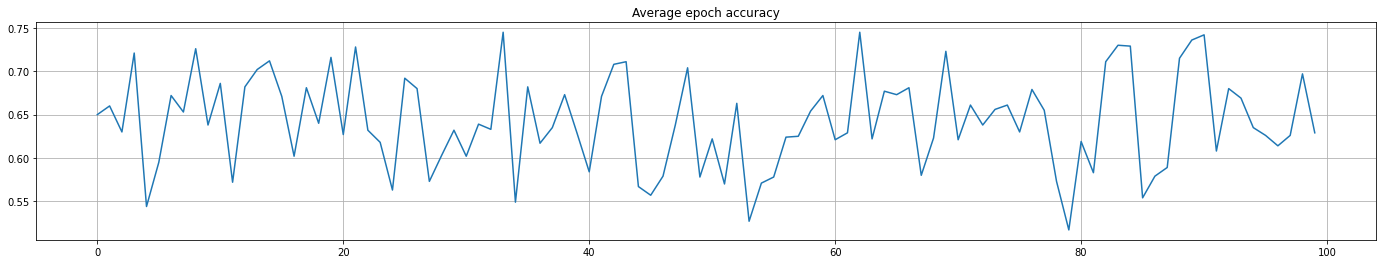

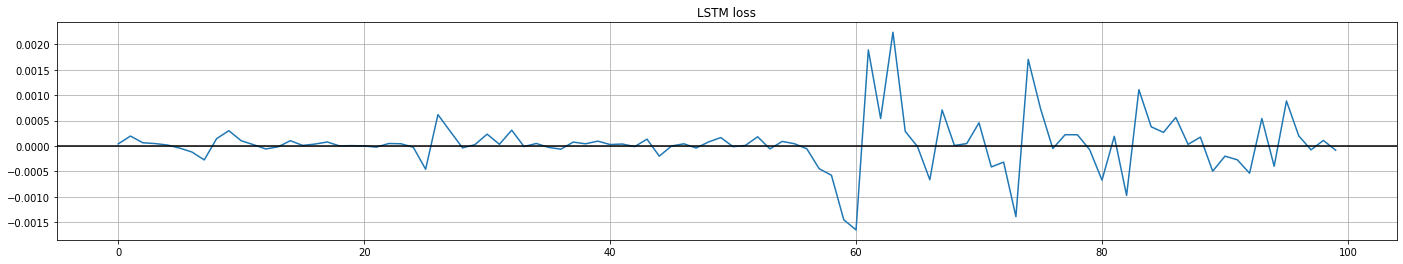

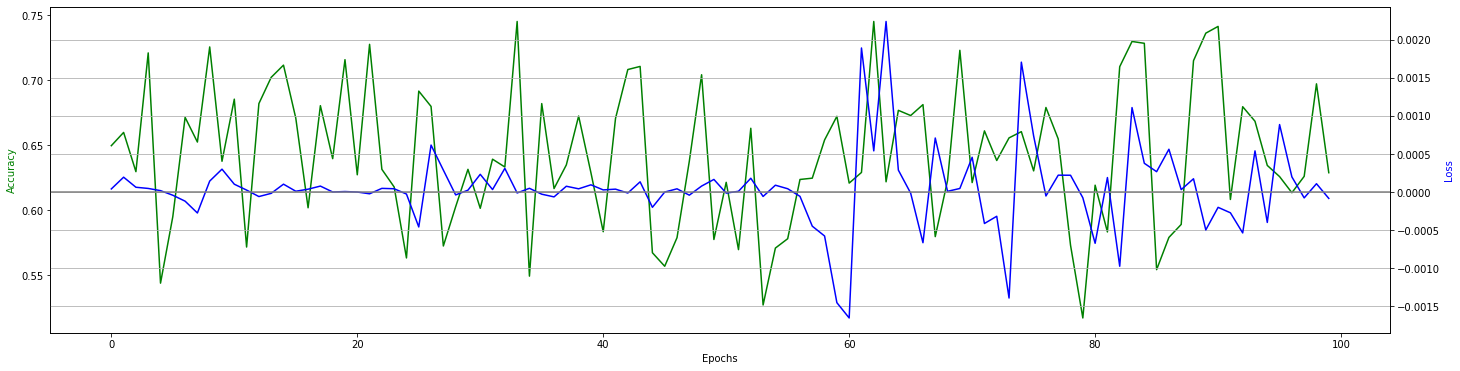

In [16]:
fig = plt.figure(figsize=(24, 4))
plt.plot(np.arange(0,len(history_avg_acc)), history_avg_acc)
plt.title("Average epoch accuracy")
plt.grid()
plt.show()
fig = plt.figure(figsize=(24, 4))
plt.plot(np.arange(0,len(history_lstm_loss)), history_lstm_loss)
plt.title("LSTM loss")
plt.axhline(y=0, c="k")
plt.grid()
plt.show()

fig, ax1 = plt.subplots(figsize=(24, 6))
ax2 = ax1.twinx()

all_acc_avg = [[np.average(i)] for i in history_data_acc]
all_acc_avg = [item for sublist in all_acc_avg for item in sublist]

ax1.plot(np.arange(0,len(all_acc_avg)), all_acc_avg, c="g")
ax2.plot(np.arange(0,len(history_lstm_loss)), history_lstm_loss, c="b")
ax2.axhline(y=0, c="gray")

ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy", color='g')
ax2.set_ylabel("Loss", color='b')
plt.grid()
plt.show()

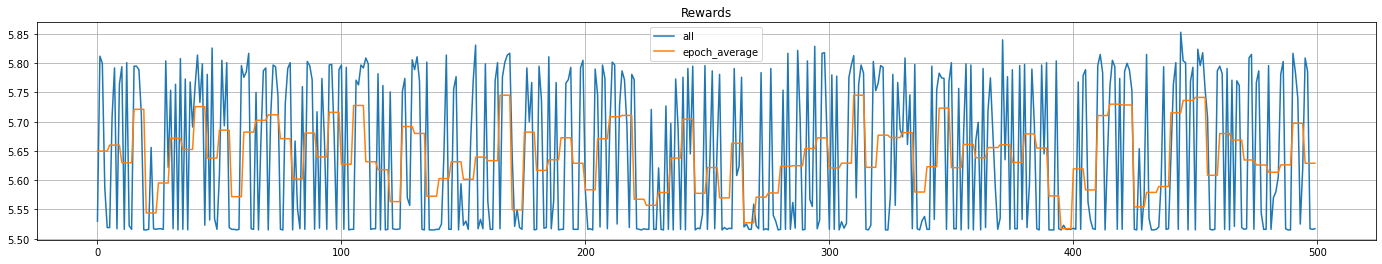

In [17]:
fig = plt.figure(figsize=(24, 4))
all_rew = np.array(history_rewards)
all_rew = all_rew.reshape(all_rew.shape[0]*all_rew.shape[1],1)

rewards_avg = [[np.average(i)]*no_of_samples_per_epoch for i in history_rewards]
rewards_avg = [item for sublist in rewards_avg for item in sublist]

plt.plot(np.arange(0,len(all_rew)), all_rew, label="all")
plt.plot(np.arange(0,len(rewards_avg)), rewards_avg, label="epoch_average")
plt.title("Rewards")
plt.legend()
plt.grid()
plt.show()

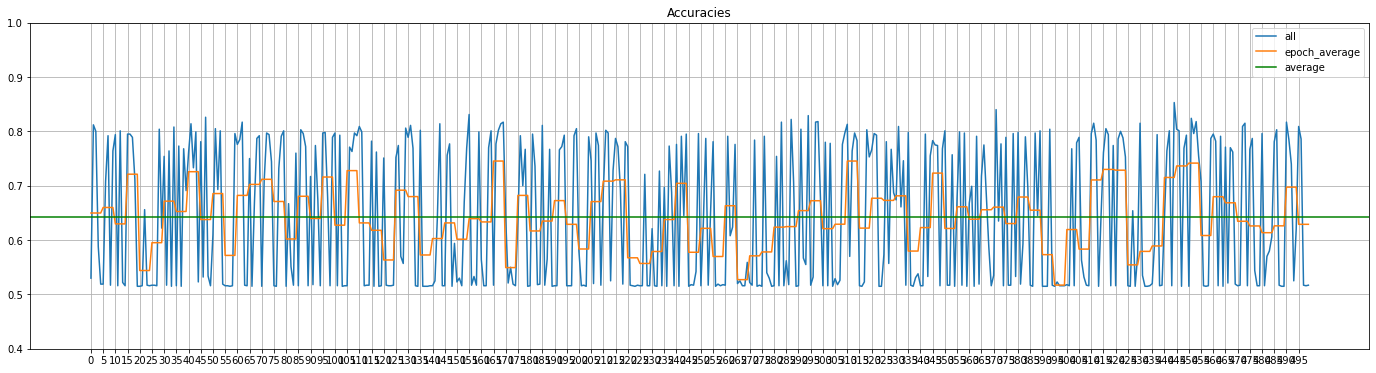

Total accuracy average: 0.642448
Best accuracy: 0.853


In [18]:
fig = plt.figure(figsize=(24, 6))
all_acc = np.array(history_data_acc)
all_acc = all_acc.reshape(all_acc.shape[0]*all_acc.shape[1],1)
plt.plot(np.arange(0,len(all_acc)), all_acc, label="all")

all_acc_avg = [[np.average(i)]*no_of_samples_per_epoch for i in history_data_acc]
all_acc_avg = [item for sublist in all_acc_avg for item in sublist]
plt.plot(np.arange(0,len(all_acc_avg)), all_acc_avg, label="epoch_average")

# plt.axhline(y=baseline, c="r", label="baseline")
plt.axhline(y=np.average(all_acc), c="g", label="average")
plt.title("Accuracies")
plt.xticks(range(0,len(all_acc), no_of_samples_per_epoch))
plt.ylim([0.4,1])
plt.grid()
plt.legend()
plt.show()
print("Total accuracy average:", np.average(all_acc))
print("Best accuracy:", np.max(all_acc))

In [19]:
# random_acc = []
# for i in range(len(all_acc)):
#     random_acc.append(performance_estimate(np.random.randint(low=1, high=len(distribution_space), size=max_no_of_layers)))

# fig = plt.figure(figsize=(24, 6))
# plt.plot(np.arange(0,len(random_acc)), random_acc)
# plt.ylim([0,1])
# plt.grid()
# plt.xticks(range(0,len(all_acc), no_of_samples_per_epoch))
# plt.axhline(y=baseline, c="r")
# plt.axhline(y=np.average(random_acc), c="g")
# plt.title("Random")
# plt.show()
# print(np.average(random_acc))